In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import matplotlib.ticker as mtick
from scipy.stats import chi2_contingency
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Package que j'ai utiliser pour le VIX
import pandas_datareader.data as web
import datetime as dt

ModuleNotFoundError: No module named 'catboost'

In [4]:
df = pd.read_pickle("/Users/arthurdestribats/Downloads/data_propre.pkl")

In [5]:
pd.options.display.max_columns = None
df.head()

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,LocationID,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,NAICSDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd
1,7A,COTTMAN TRANSMISSION,4210 RED BLUFF RD,PASADENA,TX,77503,262382.0,Loans from Old Closed Lenders,NaN,409 3rd Street S.W.,Washington,DC,20416,460400.0,345300.0,10/01/1999,2000,10/31/1999,Preferred Lenders Program,Guaranty,217,811113.0,Automotive Transmission Repair,HARRIS,TX,HOUSTON DISTRICT OFFICE,29.0,CORPORATION,1,0,12.0,Y
2,7A,GOSSELIN & SON TRUCKING INC,660 OLD FALL RIVER RD,NORTH DARTMOUTH,MA,2747,9551.0,"Bank of America, National Association",3510.0,100 North Tryon Street,Charlotte,NC,28255,36000.0,18000.0,10/01/1999,2000,10/31/1999,SBA Express Program,FA$TRK (Small Loan Express),36,NaN,NaN,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,9.0,CORPORATION,0,0,2.0,NaN
3,7A,Vande Hey Company Inc.,N2093 COUNTY ROAD N,APPLETON,WI,54915,75939.0,"Associated Bank, National Association",5296.0,200 N Adams St,GREEN BAY,WI,54301,100000.0,80000.0,10/01/1999,2000,11/30/1999,7a General,Guaranty,120,NaN,NaN,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,6.0,CORPORATION,0,0,0.0,N
4,7A,NORTHSTAR ANIMAL CLINIC PC,2004 BLACKBURN RD.,SACHSE,TX,75048,71616.0,LegacyTexas Bank,18843.0,PO Box 869111,Plano,TX,75024,151000.0,113250.0,10/01/1999,2000,12/31/1999,Preferred Lenders Program,Guaranty,84,235410.0,Masonry and Stone Contractors,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,3.0,CORPORATION,0,0,3.0,NaN
5,7A,HOLLY INN PARTNERSHIP,153 AMPEY RD.,PAW PAW,MI,49079,58036.0,Fifth Third Bank,6672.0,38 Fountain Sq Plz,CINCINNATI,OH,45263,653000.0,489750.0,10/01/1999,2000,10/31/2000,Preferred Lenders Program,Guaranty,180,551112.0,Offices of Other Holding Companies,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,6.0,PARTNERSHIP,0,0,23.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1078960 entries, 1 to 331032
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Program                1078960 non-null  object 
 1   BorrName               1078941 non-null  object 
 2   BorrStreet             1078950 non-null  object 
 3   BorrCity               1078960 non-null  object 
 4   BorrState              1078960 non-null  object 
 5   BorrZip                1078960 non-null  int64  
 6   LocationID             1078289 non-null  float64
 7   BankName               1078960 non-null  object 
 8   BankFDICNumber         987514 non-null   float64
 9   BankStreet             1078288 non-null  object 
 10  BankCity               1078289 non-null  object 
 11  BankState              1078286 non-null  object 
 12  BankZip                1078289 non-null  object 
 13  GrossApproval          1078960 non-null  float64
 14  SBAGuaranteedApproval  1

In [7]:
df["ApprovalDate"]= pd.to_datetime(df["ApprovalDate"], errors='coerce')
df = df.set_index("ApprovalDate")

In [8]:
df.index.min()

Timestamp('1999-10-01 00:00:00')

In [9]:
df.index.max()

Timestamp('2025-07-02 00:00:00')

In [10]:
df.columns

Index(['Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip',
       'LocationID', 'BankName', 'BankFDICNumber', 'BankStreet', 'BankCity',
       'BankState', 'BankZip', 'GrossApproval', 'SBAGuaranteedApproval',
       'ApprovalFY', 'FirstDisbursementDate', 'ProcessingMethod', 'Subprogram',
       'TerminMonths', 'NAICSCode', 'NAICSDescription', 'ProjectCounty',
       'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict',
       'BusinessType', 'LoanStatus', 'RevolverStatus', 'JobsSupported',
       'CollateralInd'],
      dtype='object')

- Période des données : On a des contrats qui vont d'octobre 1990 à juillet 2025
- La colonne programme ne sert à rien ici sachant que les prêts dans cette table concernent toujours le même programme
- Les noms des entreprises ne vont pas servir non plus dans la modélisation (trop de noms à encoder et dans tout les cas trop de granularité), on doit aussi enlever l'adresse exacte, la ville (car on a le code postal)
- LocationID (SBA's unique lender ID code) ne sert à rien ici sachant qu'on a deja des variables liées
- BankStreet, BankCity, BankFDICNumber, Bankzip sont également à enlever (par contre on garde le nom de la banque mais à voir pour l'encodage car 4000 banques diff)
- NAICSDescription (variable textuelle donc à enlever ou traitement de texte à faire ?) en plus redondant avec NAICcode
- CongressionalDistrict à enlever car on a deja le 'state' et le "county" du projet
- Le reste à garder

In [11]:
df = df.drop_duplicates()

In [12]:
df = df.drop(columns={'Program',
                      'BorrName',
                      'BorrStreet',
                      'BorrCity',
                      'LocationID',
                      'BankFDICNumber',
                      'BankZip',
                      'BankStreet',
                      'BankCity',
                      'NAICSDescription',
                      'CongressionalDistrict'
})

In [13]:
print(df.shape)
df.columns

(1078336, 20)


Index(['BorrState', 'BorrZip', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1078336 entries, 1999-10-01 to 2025-07-02
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   BorrState              1078336 non-null  object 
 1   BorrZip                1078336 non-null  int64  
 2   BankName               1078336 non-null  object 
 3   BankState              1077662 non-null  object 
 4   GrossApproval          1078336 non-null  float64
 5   SBAGuaranteedApproval  1078336 non-null  float64
 6   ApprovalFY             1078336 non-null  int64  
 7   FirstDisbursementDate  1076467 non-null  object 
 8   ProcessingMethod       1078336 non-null  object 
 9   Subprogram             1078336 non-null  object 
 10  TerminMonths           1078336 non-null  int64  
 11  NAICSCode              1061457 non-null  float64
 12  ProjectCounty          1078336 non-null  object 
 13  ProjectState           1078336 non-null  object 
 14  SBA

In [15]:
# Mise au format date
df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"])

### Traitement des valeurs manquantes

#### A) Variables numériques

In [16]:
# Pas de valeurs manquantes pour les variables numériques
col_numericals = ["GrossApproval", "SBAGuaranteedApproval", "TerminMonths", "JobsSupported"]
df[col_numericals].isna().sum()

GrossApproval            0
SBAGuaranteedApproval    0
TerminMonths             0
JobsSupported            0
dtype: int64

#### B) Variables restantes

In [17]:
col_restants = [col for col in df.columns if col not in col_numericals]
df[col_restants].isna().sum()

BorrState                    0
BorrZip                      0
BankName                     0
BankState                  674
ApprovalFY                   0
FirstDisbursementDate     1869
ProcessingMethod             0
Subprogram                   0
NAICSCode                16879
ProjectCounty                0
ProjectState                 0
SBADistrictOffice            0
BusinessType                 0
LoanStatus                   0
RevolverStatus               0
CollateralInd            85859
dtype: int64

In [18]:
# On voit que lorsque Bankstate est manquant on a MISSINGMAINBANKID comme nom de banque (inconnu)
df.loc[df["BankState"].isna()]

# On va donc imputer ces valeurs dans une catégorie "unknown"
df["BankName"] = np.where(df["BankName"]=="MISSINGMAINBANKID", "unknown", df["BankName"])
df["BankState"] = np.where(df["BankState"].isna(), "unknown", df["BankState"])
print(f'Nombre de lignes imputées {df[df["BankState"] == "unknown"].shape[0]}')

Nombre de lignes imputées 674


In [19]:
# Les lignes ou FirstDisbursementDate est manquant les autres variables sont renseignées
df.loc[df['FirstDisbursementDate'].isna()]
# Sachant que le premier versement arrive après un certain temps de la date d'approbation on peut prendre la médiane (dans tout les cas ca n'aura pas un grand impact car peu de valeurs manquantes)
approval_dates = df.index.to_series()
delai_median = (df['FirstDisbursementDate'] - approval_dates).median()
valeurs_remplacement = approval_dates + delai_median
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].fillna(valeurs_remplacement)

In [20]:
# Pour la variable CollateralInd on a deux possibilités (oui/non), pour povuoir garder la variable on fait l'hypothèse que NaN = No
df["CollateralInd"]=df["CollateralInd"].fillna(0)
df["CollateralInd"] = np.where(df['CollateralInd'] == "Y", 1, 0)
df.CollateralInd.value_counts()

CollateralInd
0    647768
1    430568
Name: count, dtype: int64

In [21]:
# Seule possibilité est d'imputer par 'inconnu' pour NAICSCode
df["NAICSCode"] = df["NAICSCode"].fillna("inconnu")

### Analyse des variables numériques

In [22]:
# Variables quanti
df_num = df[col_numericals]

In [23]:
df_num.describe().round(3)

,GrossApproval,SBAGuaranteedApproval,TerminMonths,JobsSupported
count,1078336.000,1078336.000,1078336.000,1078336.000
mean,255694.676,187501.843,103.424,9.078
std,503925.074,388533.565,72.075,24.738
min,55.000,46.750,0.000,0.000
25%,25400.000,15000.000,60.000,1.000
50%,80000.000,50000.000,84.000,4.000
75%,250000.000,175000.000,120.000,10.000
max,5000000.000,4500000.000,569.000,9500.000


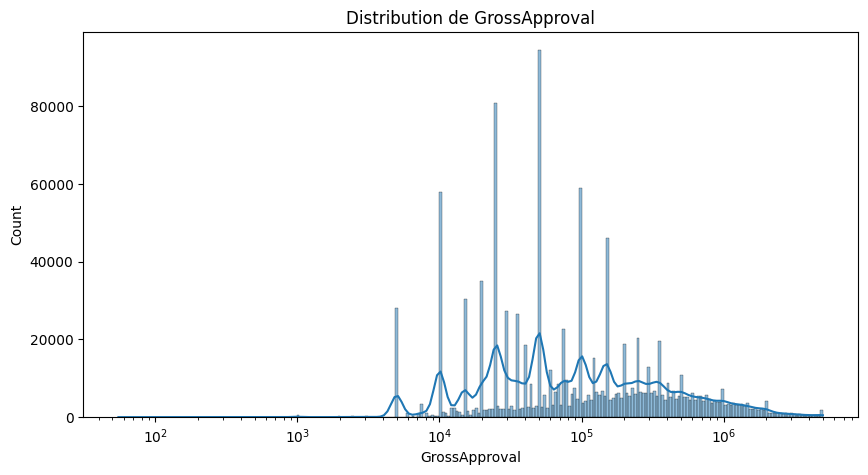

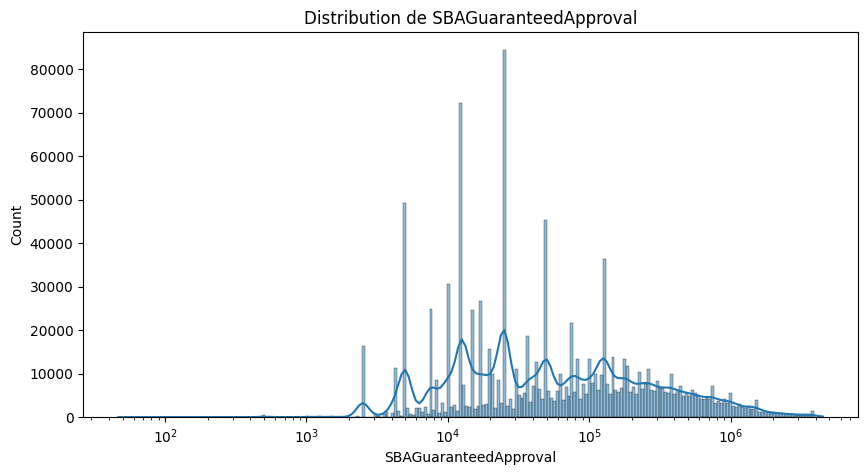

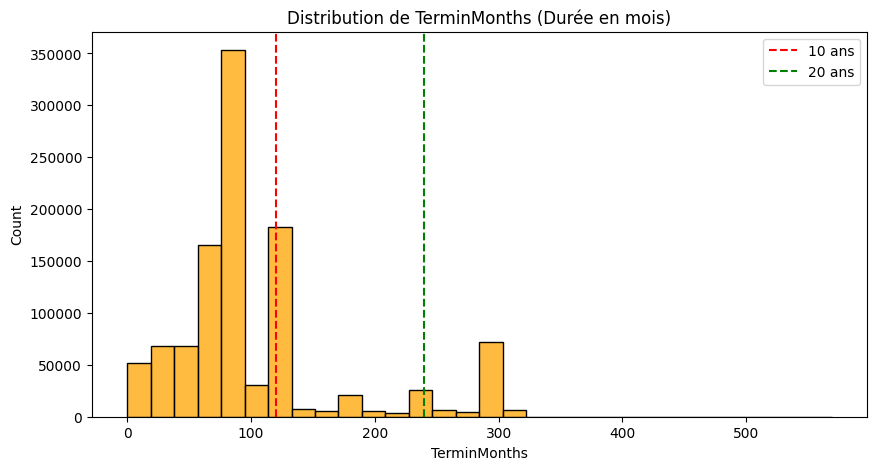

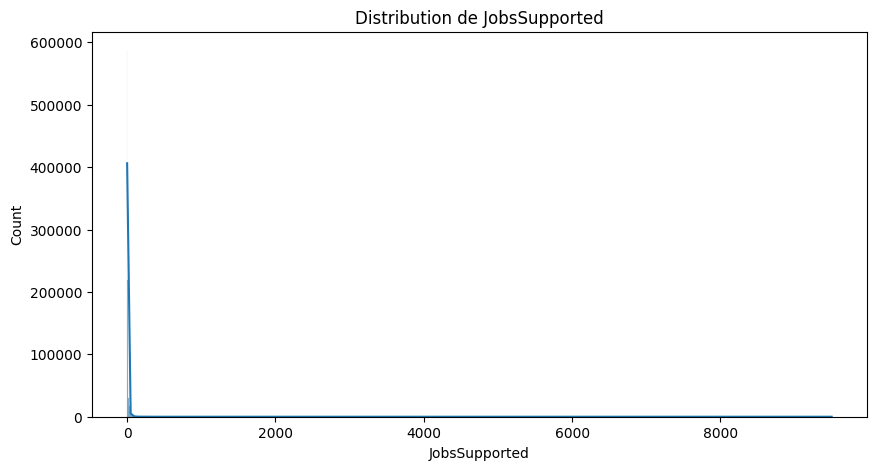

In [24]:
#Visualisation graphique
for col in df_num.columns:
    plt.figure(figsize=(10, 5))

    if "Approval" in col:
        sns.histplot(data=df, x=col, kde=True, log_scale=True)
        plt.title(f"Distribution de {col}")
        
    elif "Termin" in col:
        sns.histplot(data=df, x=col, kde=False, bins=30, color='orange')
        plt.title(f"Distribution de {col} (Durée en mois)")
        plt.axvline(x=120, color='r', linestyle='--', label='10 ans') # 120 mois
        plt.axvline(x=240, color='g', linestyle='--', label='20 ans') # 240 mois
        plt.legend()
    else:
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f"Distribution de {col}")

    plt.show()

- On voit qu'on a surtout à faire à des petites entreprises au vu de la distribution des emploi crées
- Les montants prêtés et garantis ont des distributions assez proches
- On a surtout à faire à des prêts de moins de 10 ans 

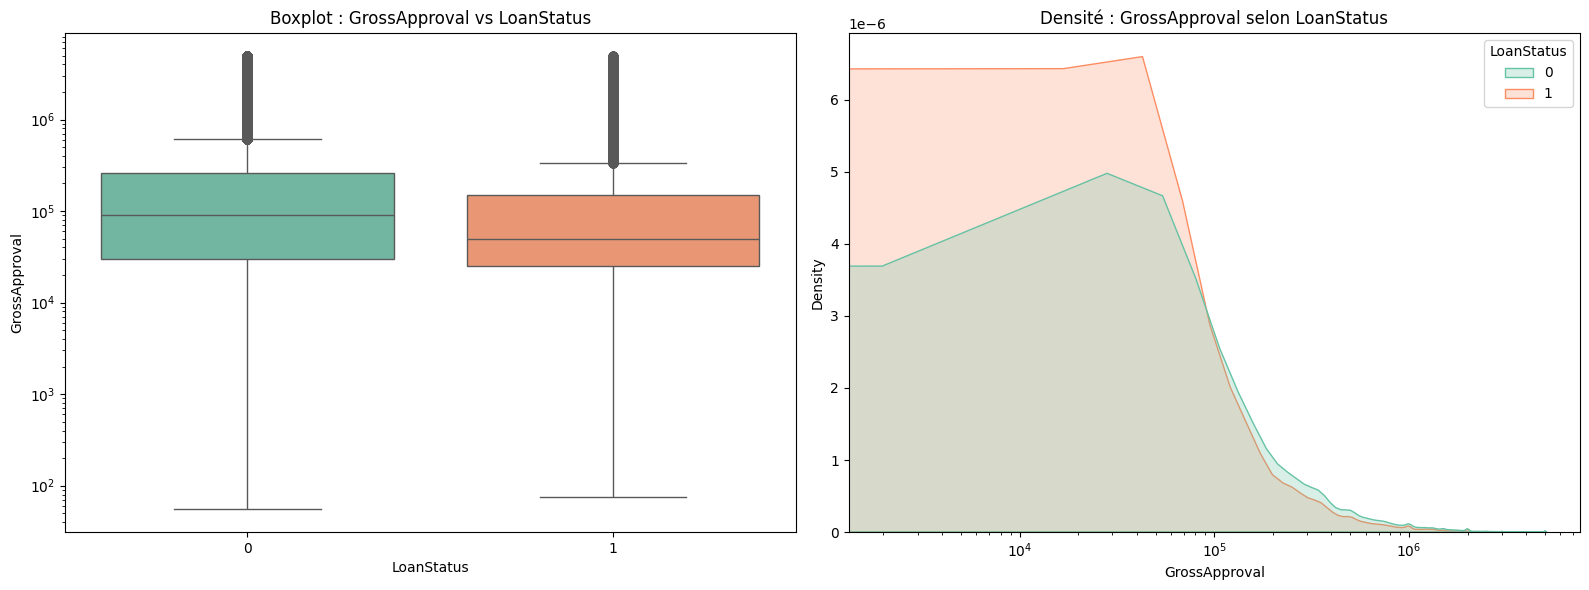

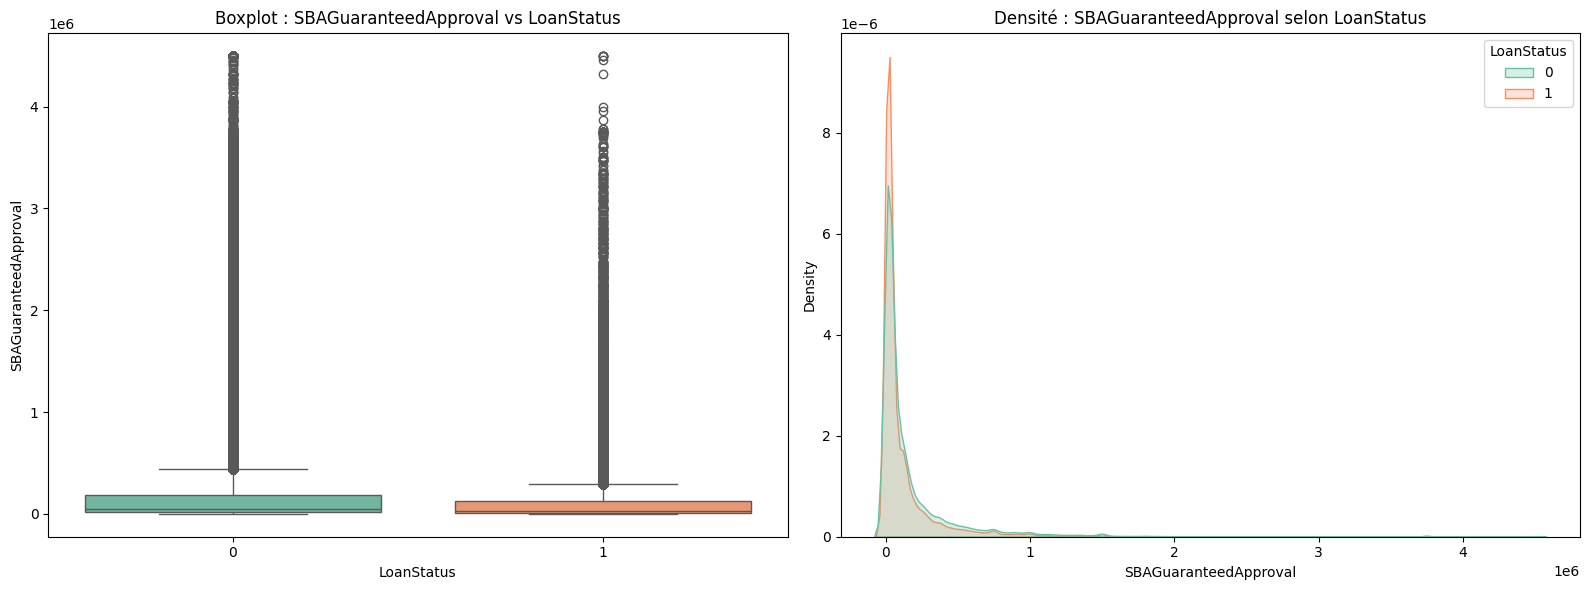

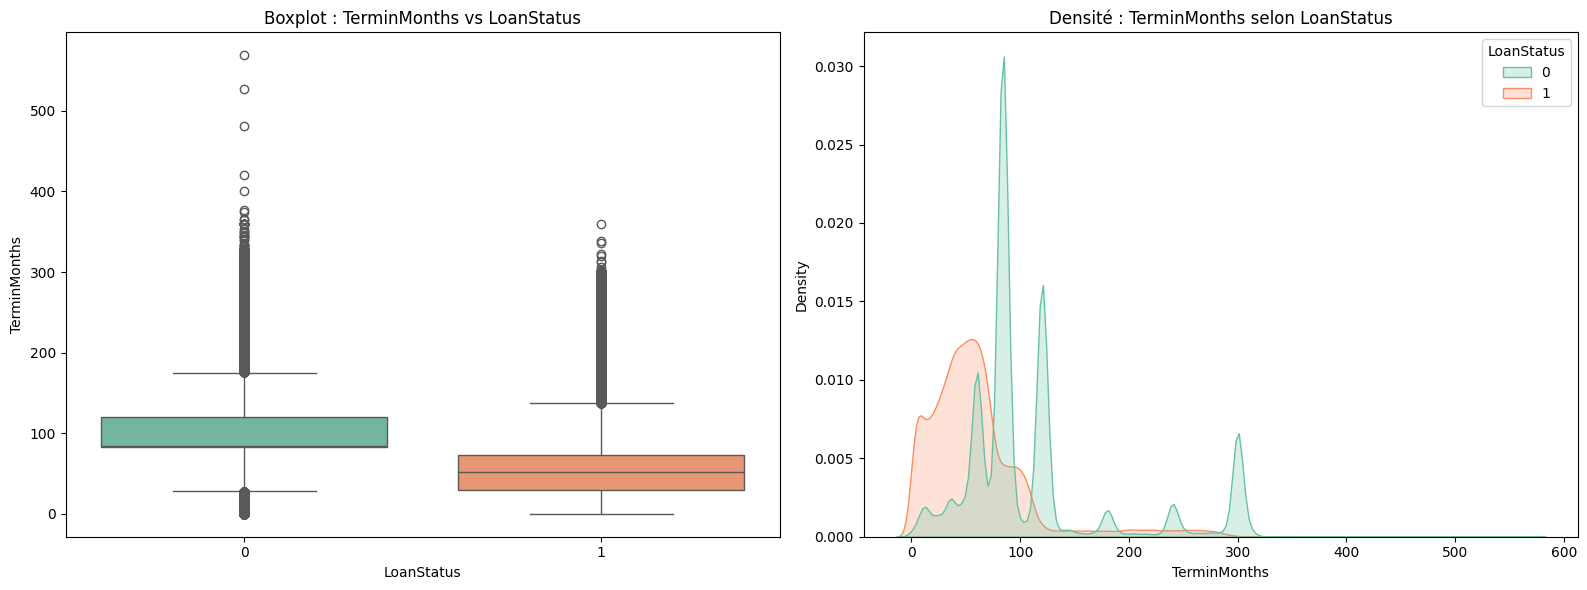

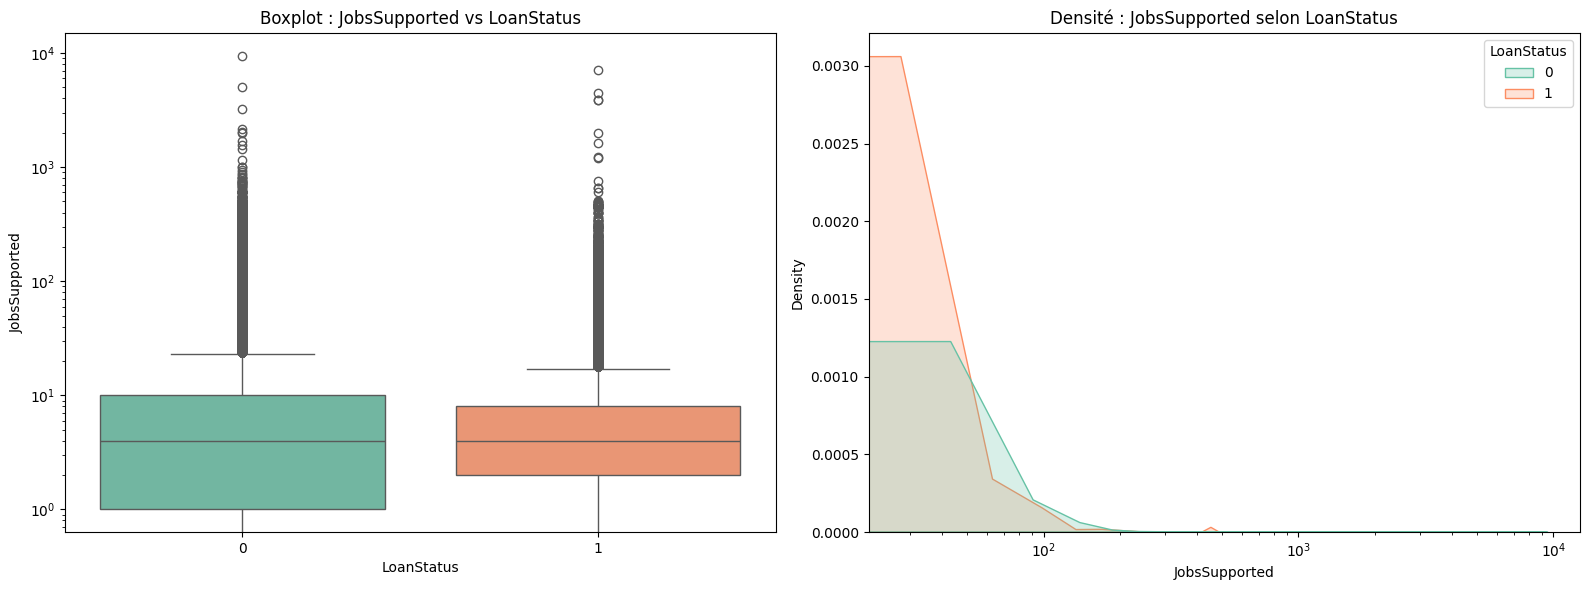

In [25]:
# Visualisation en fonction de la cible
for col in df_num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(
        data=df, 
        x='LoanStatus', 
        y=col, 
        hue='LoanStatus',  
        legend=False,    
        ax=axes[0], 
        palette="Set2"
    )
    axes[0].set_title(f"Boxplot : {col} vs LoanStatus")
    

    if col in ['GrossApproval', 'JobsSupported']:
        axes[0].set_yscale('log')
    
    sns.kdeplot(
        data=df, 
        x=col, 
        hue='LoanStatus', 
        fill=True, 
        common_norm=False, 
        ax=axes[1], 
        palette="Set2"
    )
    axes[1].set_title(f"Densité : {col} selon LoanStatus")
    
    if col in ['GrossApproval', 'JobsSupported']:
        axes[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

### Analayse de la variable cible dans le temps

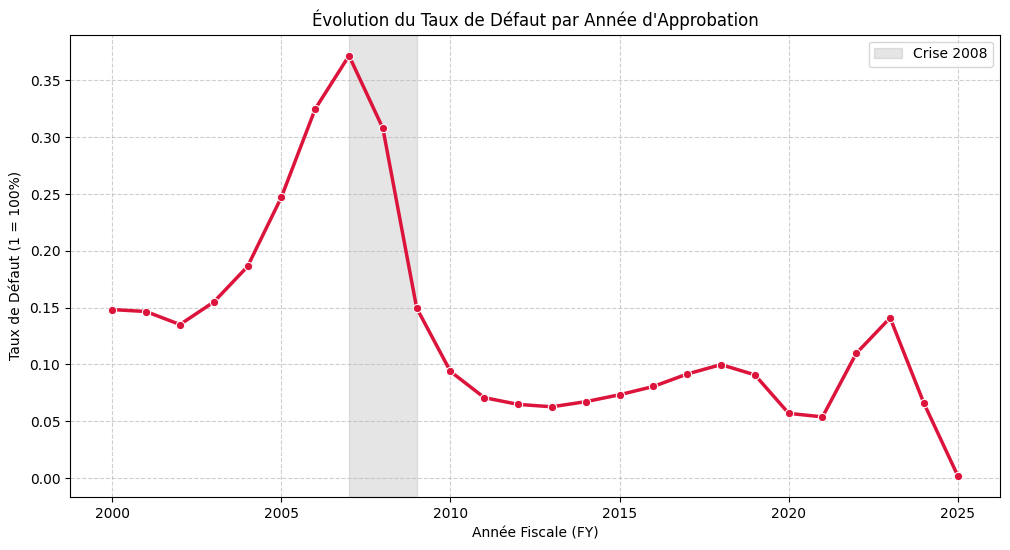

In [26]:
defaut_par_an = df.groupby('ApprovalFY')['LoanStatus'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=defaut_par_an, marker='o', color='crimson', linewidth=2.5)

plt.title("Évolution du Taux de Défaut par Année d'Approbation")
plt.ylabel("Taux de Défaut (1 = 100%)")
plt.xlabel("Année Fiscale (FY)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvspan(2007, 2009, color='gray', alpha=0.2, label='Crise 2008')
plt.legend()
plt.show()

- On voit graphiquement que de manière logique on a un pic des faillites en sur la période de la crise de 2008
- Il semble également y avoir un pic retardé de l'effet de la crise covid
- A voir si on garde la période de 2008 sachant que ca peut ajouter du bruit inutile dans le modèle (peutetre mettre une indicatrice des périodes de crise)
- On a une chute assez importante sur la dernière période (pas assez de données ?)

### Analyse des variables non numériques

In [27]:
df["BusinessType"] = np.where(df["BusinessType"]== " ", "unknown", df["BusinessType"])
df.BusinessType.value_counts()
# On supprime les lignes ou on n'a pas de business type

BusinessType
CORPORATION    854371
INDIVIDUAL     198257
PARTNERSHIP     25245
                  463
Name: count, dtype: int64

In [28]:
df = df.loc[df["BusinessType"].isin(["CORPORATION", "INDIVIDUAL", "PARTNERSHIP"])]
df.BusinessType.value_counts()

BusinessType
CORPORATION    854371
INDIVIDUAL     198257
PARTNERSHIP     25245
Name: count, dtype: int64

*Pour la variable NAICS code on peut trouver le secteur d'activité de l'entreprise à partir des deux premiers chiffres (permettra de différencier le risque selon le secteur)*

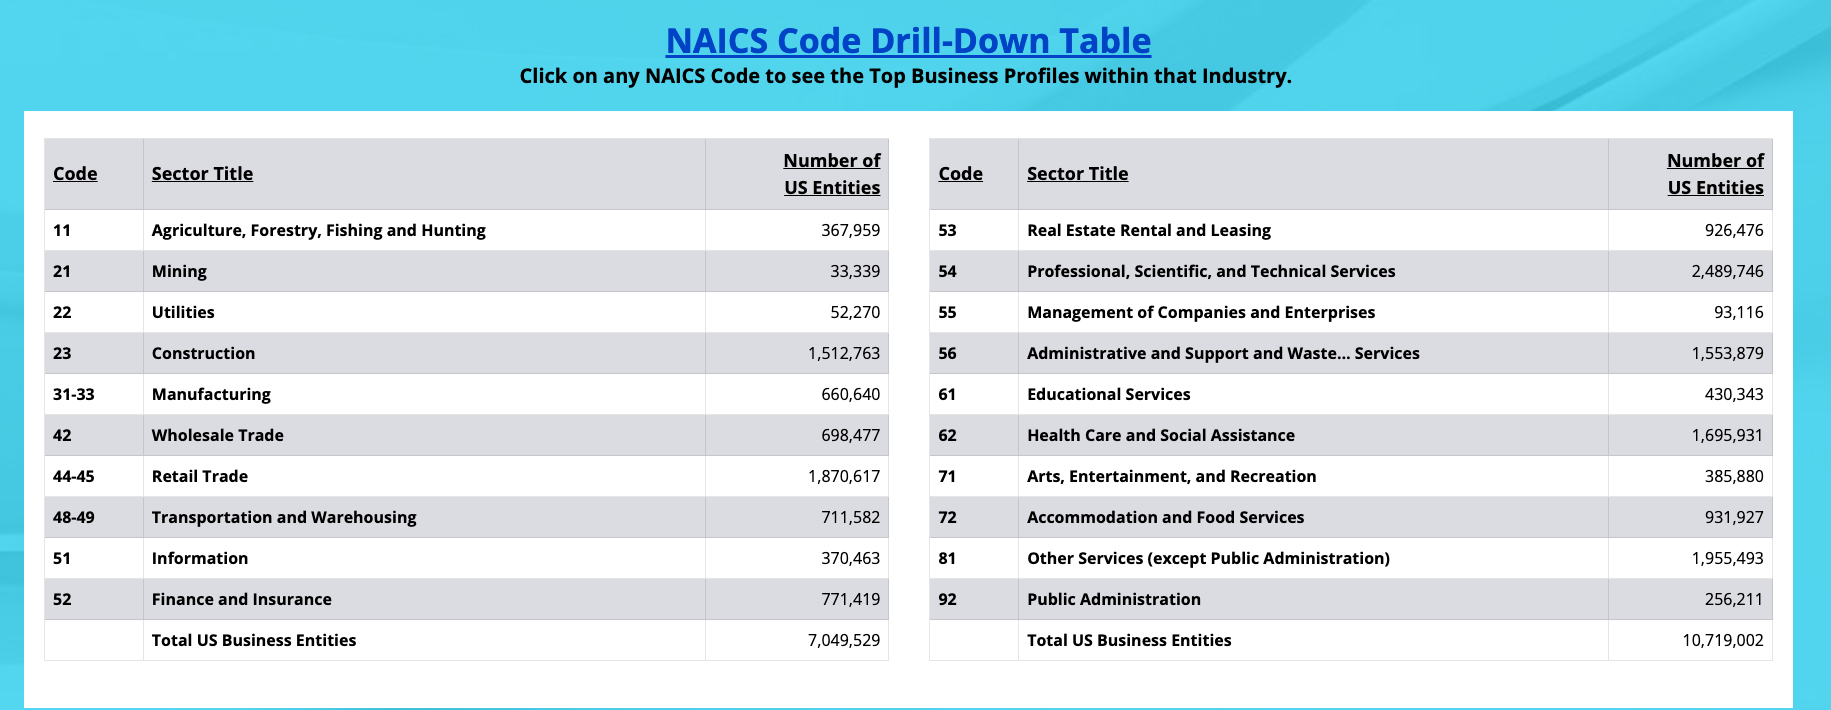

In [29]:
# Dictionnaire pour relier le cdes premiers chifres du code NAIC selon le secteur (voir image dessus)
naics_map = {
    '11': 'Agriculture', '21': 'Mining', '22': 'Utilities', '23': 'Construction',
    '31': 'Manufacturing', '32': 'Manufacturing', '33': 'Manufacturing',
    '42': 'Wholesale', '44': 'Retail', '45': 'Retail',
    '48': 'Transport', '49': 'Transport', '51': 'Information',
    '52': 'Finance', '53': 'Real Estate', '54': 'Prof. Services',
    '55': 'Management', '56': 'Admin/Waste', '61': 'Education',
    '62': 'Health Care', '71': 'Arts/Entertainment', '72': 'Accommodation/Food',
    '81': 'Other Services', '92': 'Public Admin', "in": "Inconnu"
}

# On prend les deux premiers chiffres
df['Industry'] = df['NAICSCode'].astype(str).str[:2]

# On fait le mapping du dico
df['IndustryName'] = df['Industry'].map(naics_map).fillna(df['Industry'])

# On calcule le taux de défaut par industrie
industry_risk = df.groupby('IndustryName')['LoanStatus'].mean().sort_values(ascending=False)

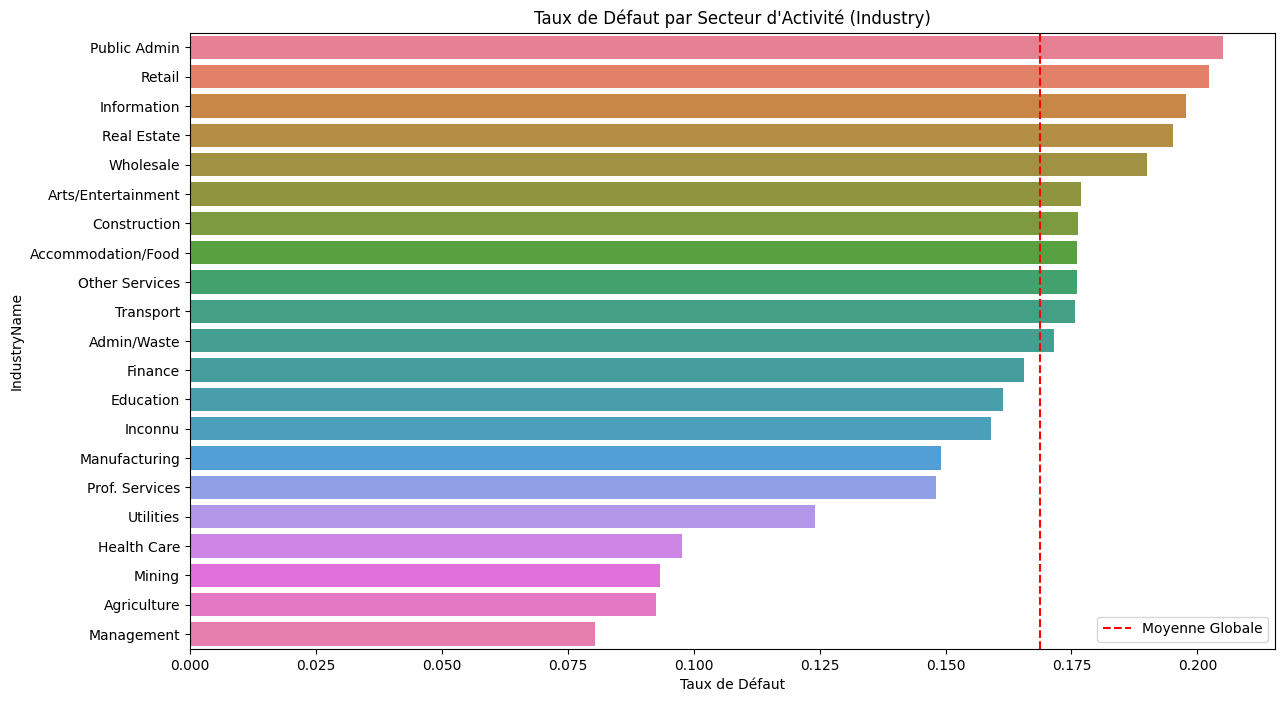

In [30]:
plt.figure(figsize=(14, 8))
sns.barplot(x=industry_risk.values, 
            y=industry_risk.index, 
            hue=industry_risk.index)
plt.title("Taux de Défaut par Secteur d'Activité (Industry)")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

On voit bien graphiquement que le risque dépend fortement du secteur d'activité avec des secteurs plus risquées que d'autres. Mais il faut faire aussi attention à la significativité de ces chiffres dans l'intérprétation.

In [31]:
# ON voit qu'on a des secteurs qui sont tr!s faiblement représentés
df.IndustryName.value_counts()

IndustryName
Retail                172035
Accommodation/Food    129762
Construction          107120
Prof. Services        104675
Other Services        101875
Manufacturing          86617
Health Care            84820
Wholesale              60292
Admin/Waste            53914
Transport              48486
Arts/Entertainment     25697
Real Estate            23099
Finance                17771
Inconnu                16811
Information            15593
Education              13077
Agriculture            12126
Mining                  2530
Utilities                943
Management               435
Public Admin             195
Name: count, dtype: int64

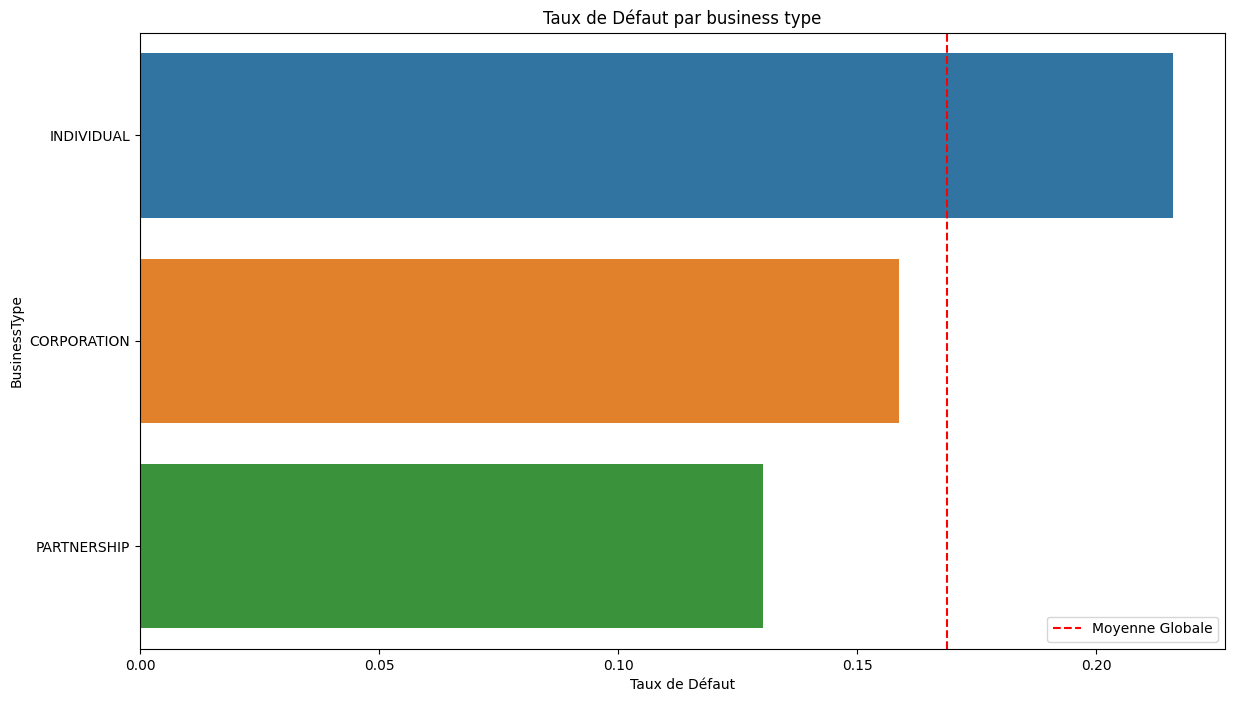

In [32]:
# Taux de défaut selon le businesstype (individuel, corpo, partnership)
business_risk = df.groupby('BusinessType')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=business_risk.values, 
            y=business_risk.index, 
            hue=business_risk.index)
plt.title("Taux de Défaut par business type")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

La encore on voit que la variable permet de bien différencier le risque, les entreprises individuels semblent bcp plus risquées que les autres types de boites

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_53595/3523158129.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


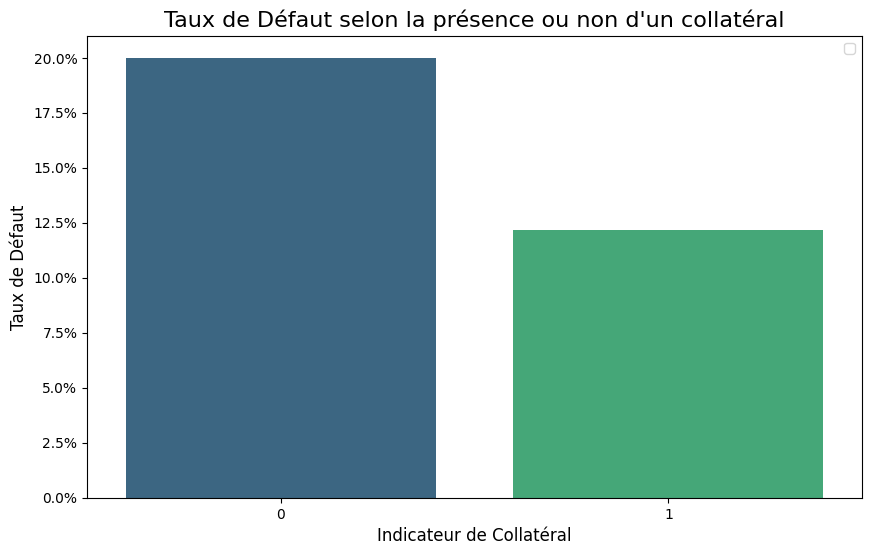

In [41]:
collat_risk = df.groupby('CollateralInd')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6)) # Format un peu plus compact pour des barres verticales
sns.barplot(x=collat_risk.index, 
            y=collat_risk.values, 
            hue=collat_risk.index, 
            legend=False, 
            palette="viridis")

plt.title("Taux de Défaut selon la présence ou non d'un collatéral", fontsize=16)
plt.xlabel("Indicateur de Collatéral", fontsize=12)
plt.ylabel("Taux de Défaut", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.show()

Les prêts sans collatéral sont logiquement plus risqués

#### Variables géographiques

In [42]:
round(df["BorrState"].value_counts(), 5)
# On voit qu'il y des régions avec trop peu d'observations (à voir s'il ne faut pas les regrouper)

BorrState
CA    140468
TX     81579
NY     71105
FL     54877
OH     49517
PA     42422
MA     35542
IL     35515
MI     34927
NJ     31955
MN     29542
WA     27767
GA     27723
WI     25874
CO     24952
UT     23901
AZ     22851
IN     21021
MO     20203
NC     19111
MD     16476
VA     16198
OR     14550
CT     14290
NH     12347
ID     10651
PR     10502
TN     10500
OK     10210
KY      9553
KS      9425
LA      9386
RI      9375
IA      9266
NV      9016
MS      8779
SC      7729
NE      7123
AL      7026
ME      6646
MT      6400
AR      6049
NM      5260
HI      5230
VT      4558
ND      4223
WV      3099
SD      3086
DE      2875
WY      2196
DC      2016
AK      1873
GU       827
VI       238
MP        20
AS        11
PW         6
MH         3
AE         2
FM         1
Name: count, dtype: int64

On a des états avec un nb d'obs très faible,  Je pense il faut regrouper lrsq le nb  d'obs de l'etat est inf à 100

In [43]:
# ON fait le choix de regrouper à partir de VI dans une catégorie Other
freq = df['BorrState'].value_counts()
state_rares = freq[freq < 239].index
df.loc[df['BorrState'].isin(state_rares), 'BorrState'] = 'Other'

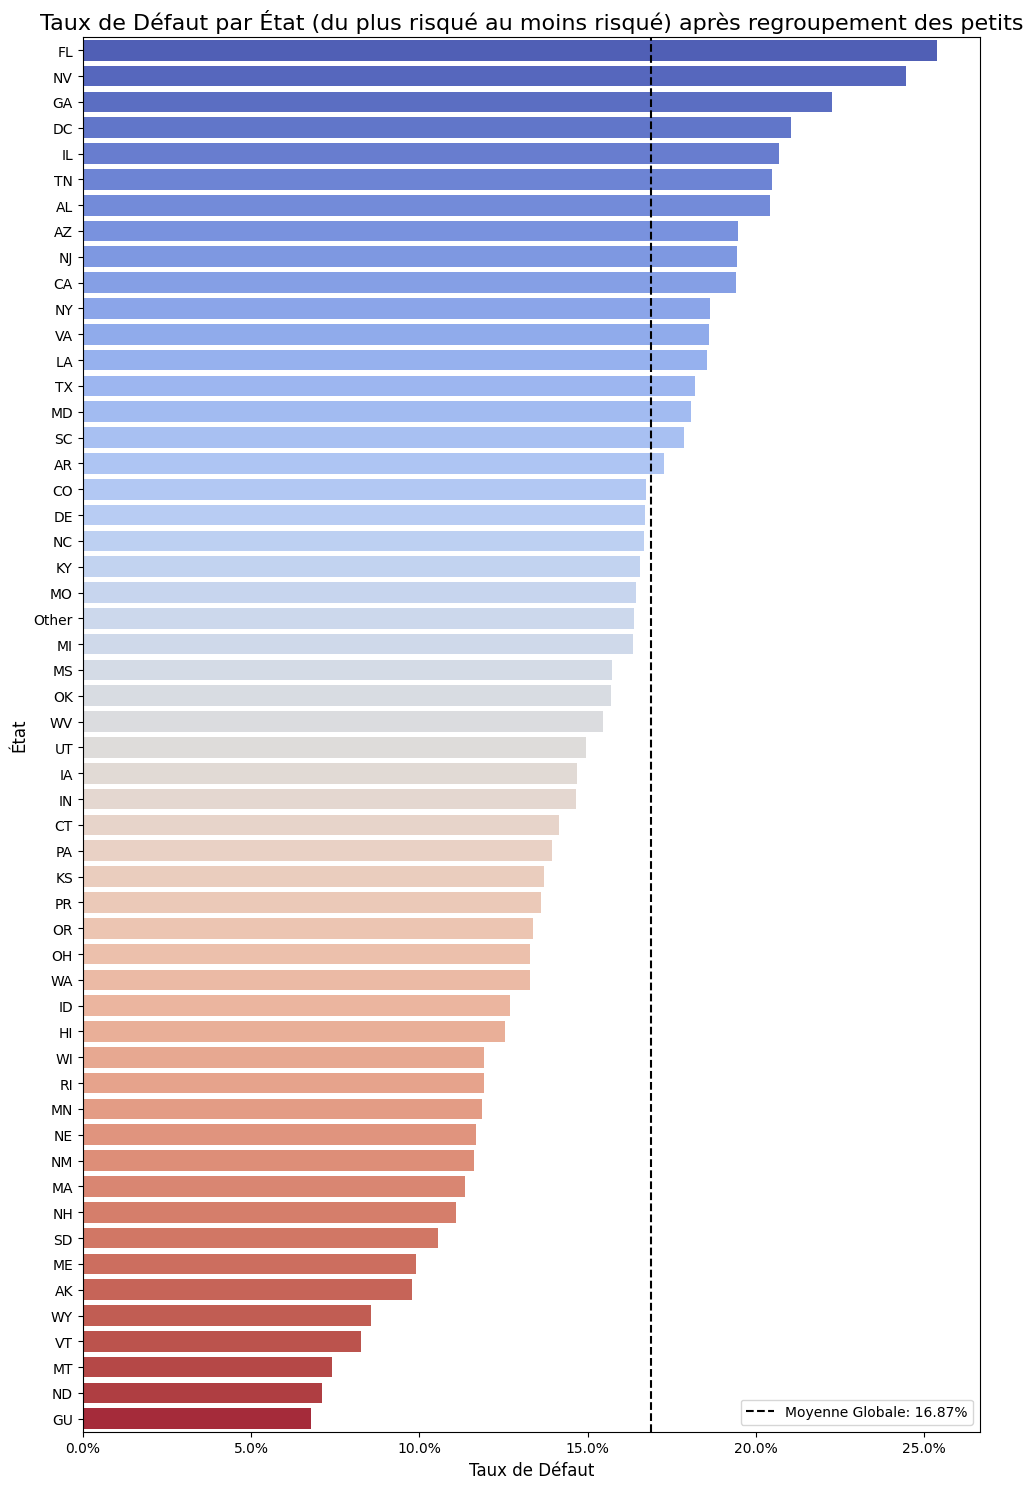

In [44]:
state_risk = df.groupby('BorrState')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 15)) 
sns.barplot(x=state_risk.values, 
            y=state_risk.index, 
            hue=state_risk.index, 
            legend=False, 
            palette="coolwarm")

plt.title("Taux de Défaut par État (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

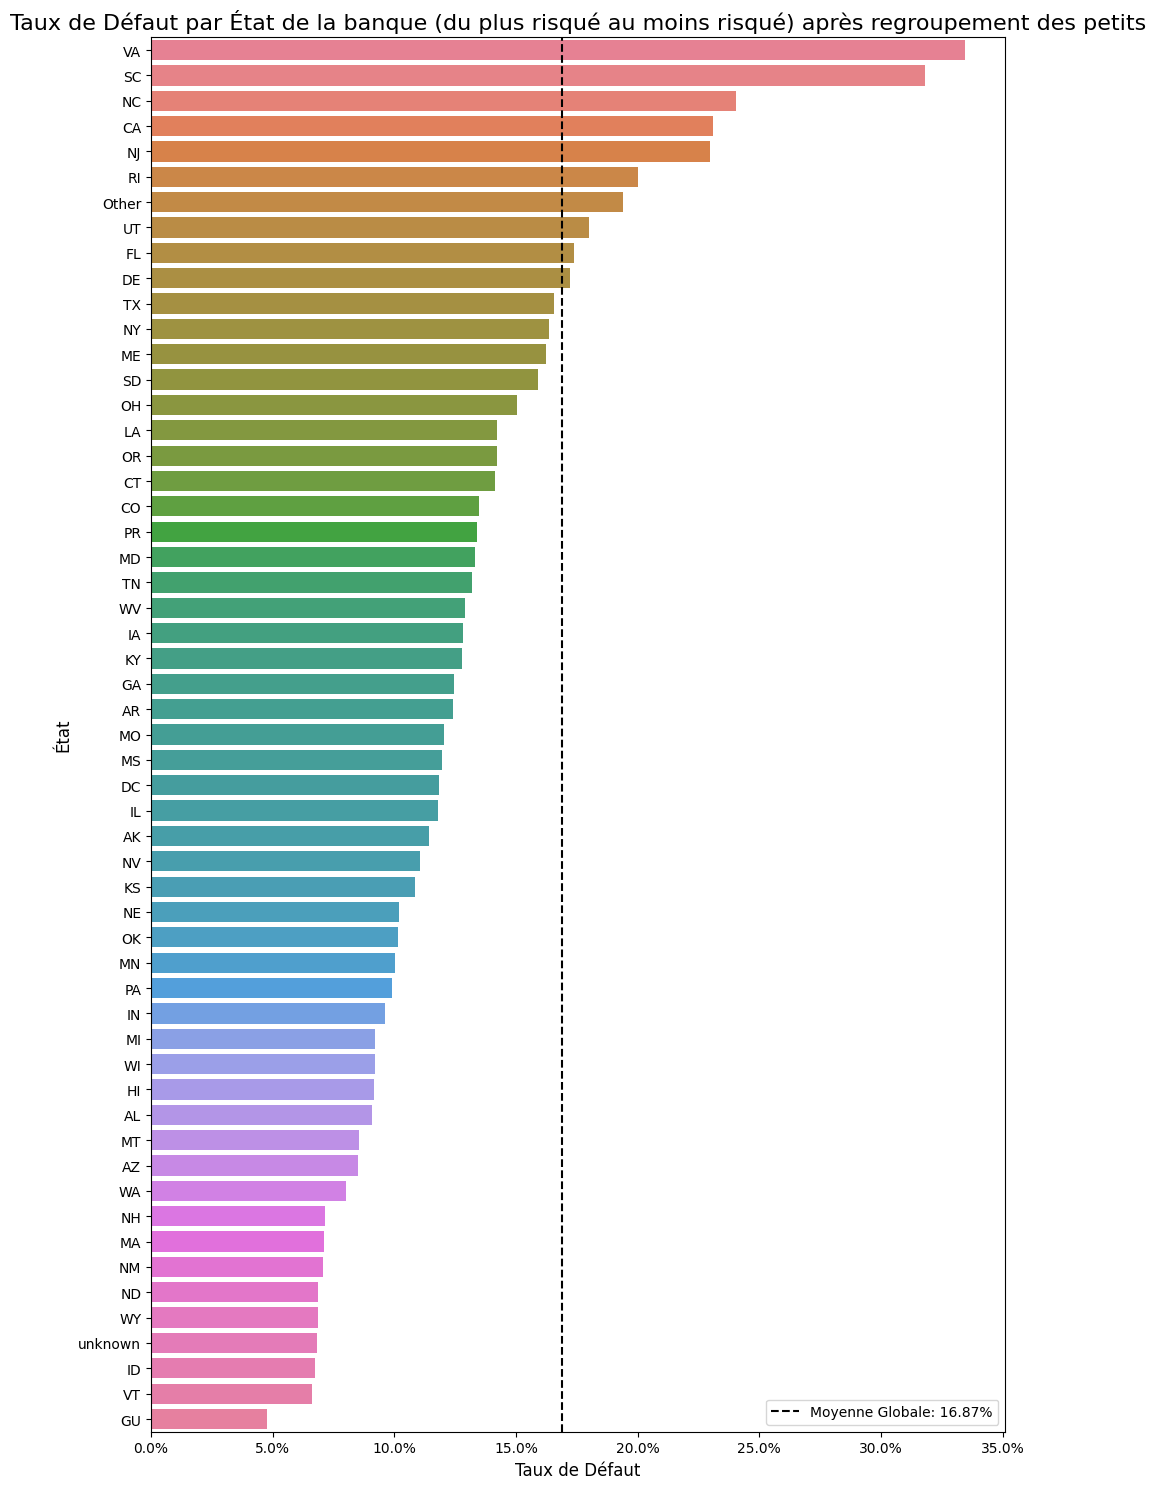

In [45]:
freq = df['BankState'].value_counts()
state_rares = freq[freq < 400].index
df.loc[df['BankState'].isin(state_rares), 'BankState'] = 'Other'

bank_state_risk = df.groupby('BankState')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=bank_state_risk.values, 
            y=bank_state_risk.index, 
            hue=bank_state_risk.index, 
            legend=False)

plt.title("Taux de Défaut par État de la banque (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

La aussi on voit que selon l'état de la banque on a des taux de défaut très différent

In [46]:
df.ProcessingMethod.value_counts()

ProcessingMethod
SBA Express Program                                             568344
Preferred Lenders Program                                       271263
7a General                                                       83766
Community Express                                                43092
Low Documentation Program                                        41998
Small Loan Advantage Initiative                                  24595
Patriot Express Loans                                             9608
Certified Lenders Program                                         9407
Community Advantage Initiative                                    4482
International Trade Loans                                         4147
Rural Loan Initiative                                             3653
Gulf Opportunity Pilot Loan Program                               2824
Standard Asset Base Working Capital Line of Credit (CAPLine)      2813
Export Express                                              

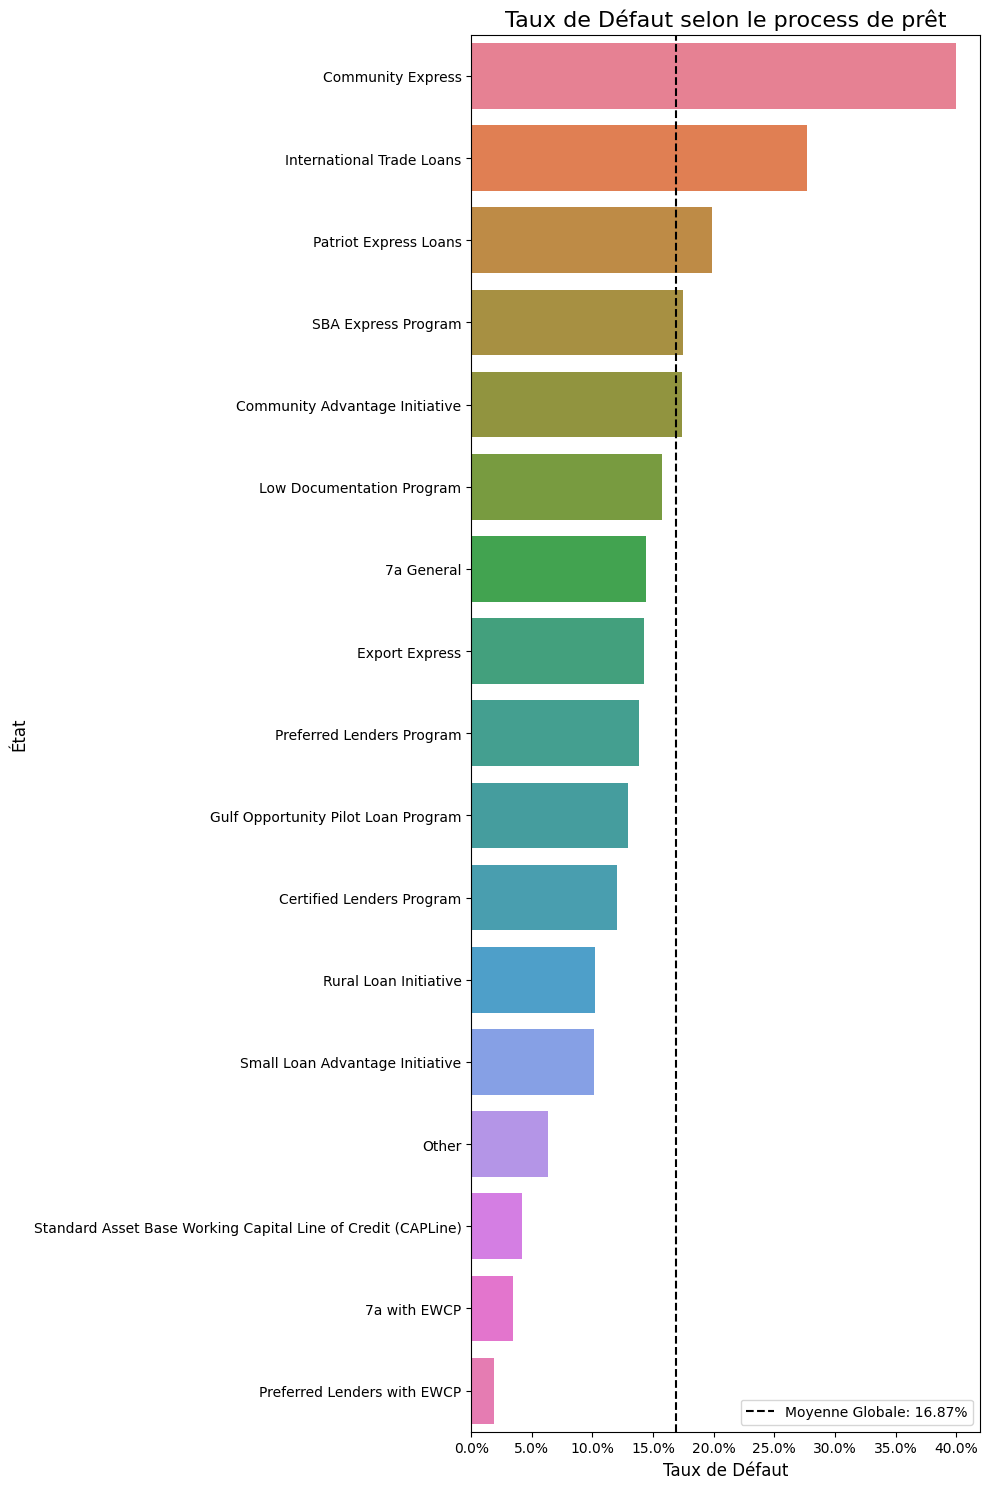

In [47]:
freq = df['ProcessingMethod'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'ProcessingMethod'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process de prêt", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

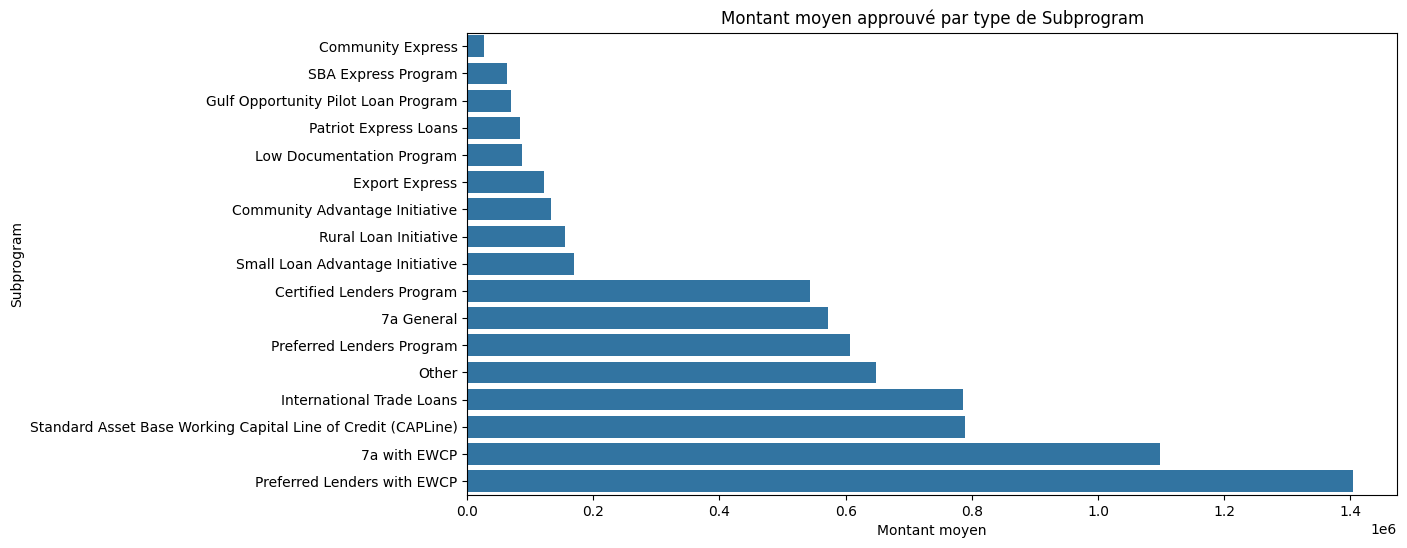

In [48]:
# 1. Calcul du montant moyen par subprogram
mean_amount_by_subprogram = (
    df.groupby("ProcessingMethod")["GrossApproval"]
      .mean()
      .sort_values(ascending=True))

df["Mean_GrossApproval_by_Subprogram"] = df["Subprogram"].map(mean_amount_by_subprogram)

plt.figure(figsize=(12,6))
sns.barplot(
    x=mean_amount_by_subprogram.values,
    y=mean_amount_by_subprogram.index
)
plt.title("Montant moyen approuvé par type de Subprogram")
plt.xlabel("Montant moyen")
plt.ylabel("Subprogram")
plt.show()

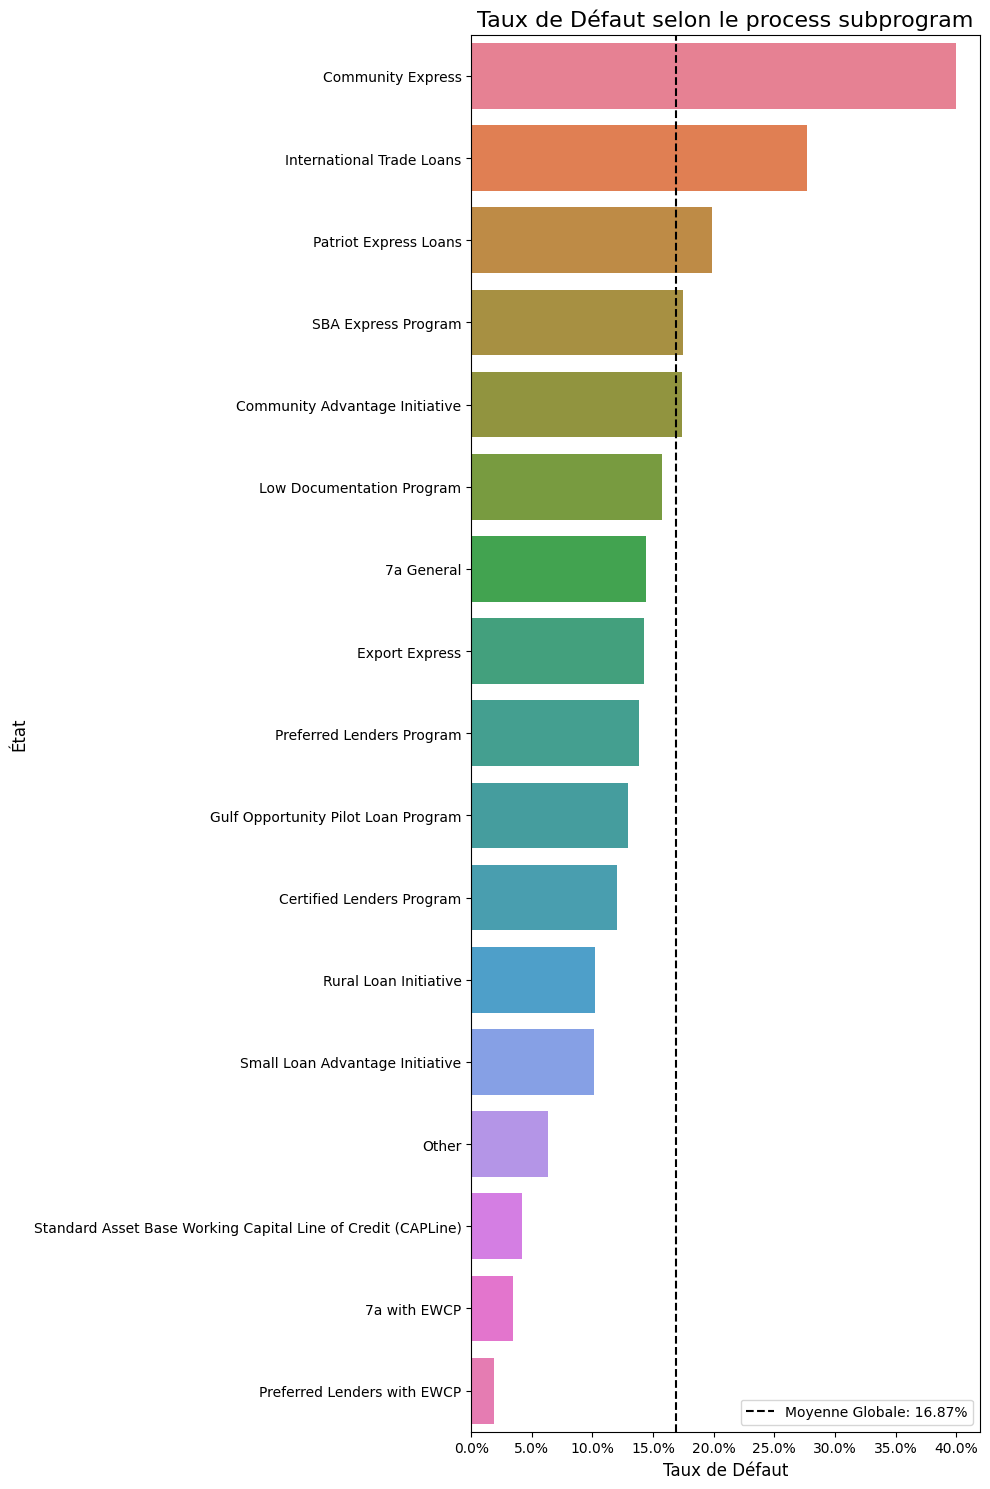

In [49]:
freq = df['Subprogram'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'Subprogram'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process subprogram", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [50]:
# Taux de défaut selon RevolverStatus
pd.crosstab(df["RevolverStatus"], df["LoanStatus"], normalize="index")

LoanStatus,0,1
RevolverStatus,,
0,0.836217,0.163783
1,0.820233,0.179767


In [51]:
# Matrice de corrélation

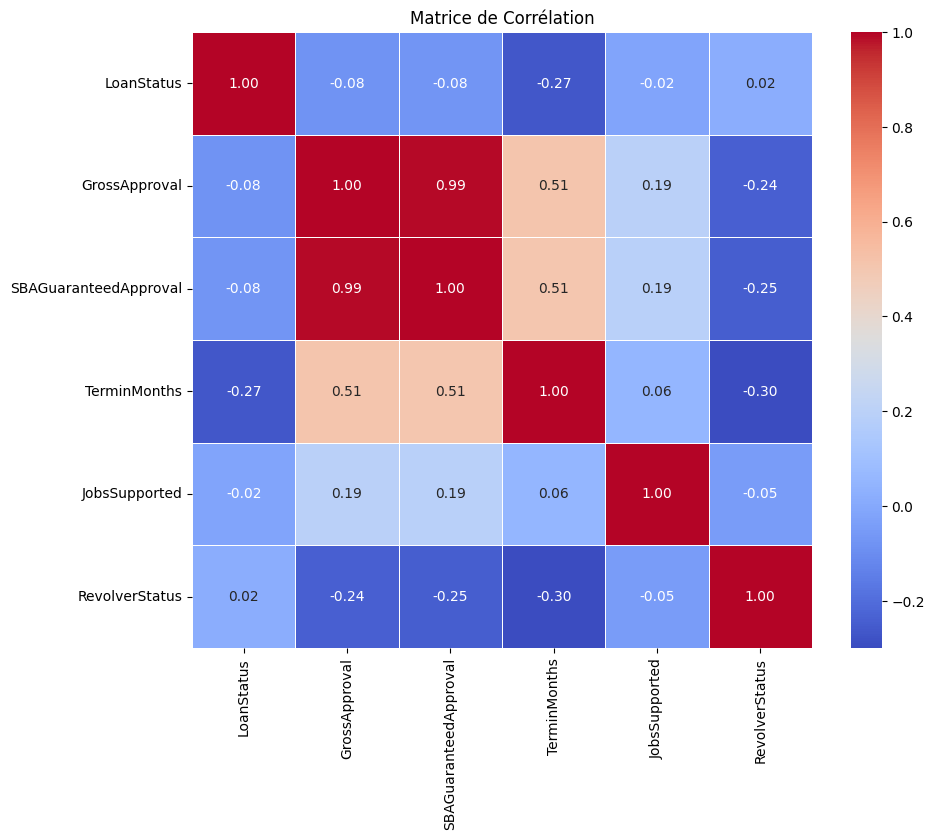

In [52]:
cols_corr = ['LoanStatus', 'GrossApproval', 'SBAGuaranteedApproval', 'TerminMonths', 'JobsSupported', 'RevolverStatus']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Feature engineering

#### A. Outliers sur les variables quanti

 Au lieu de supprimer les outliers (qui sont porteurs d'information dans ce cadre surtout qu'on en a bcp au vu des boxplot qu'on a vu au dessus) on va plutot faire une transformation logarithmique permettant d'attenuer l'effet des outliers

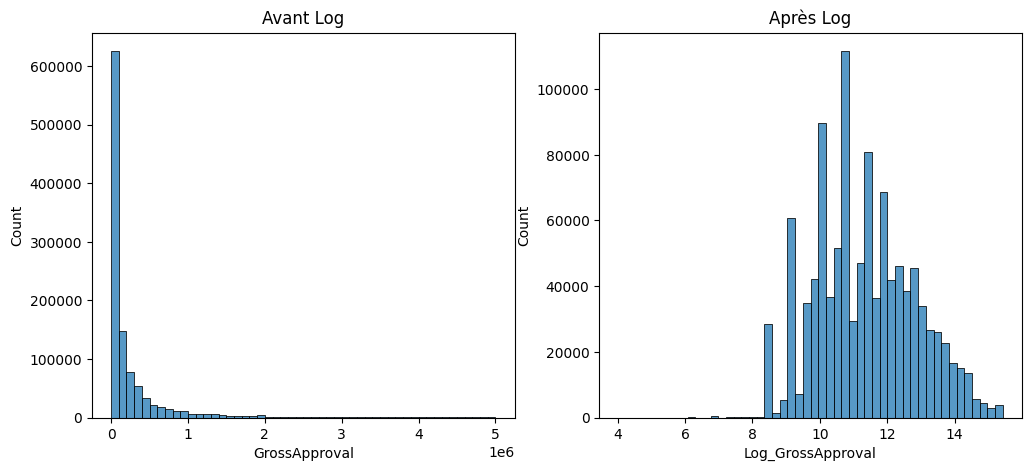

In [53]:
df['Log_GrossApproval'] = np.log1p(df['GrossApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['GrossApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_GrossApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

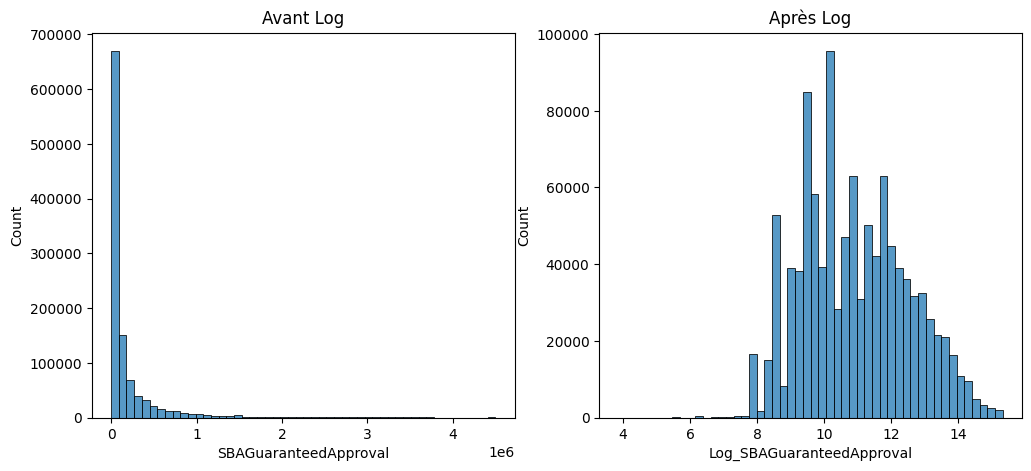

In [54]:
df['Log_SBAGuaranteedApproval'] = np.log1p(df['SBAGuaranteedApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SBAGuaranteedApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_SBAGuaranteedApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

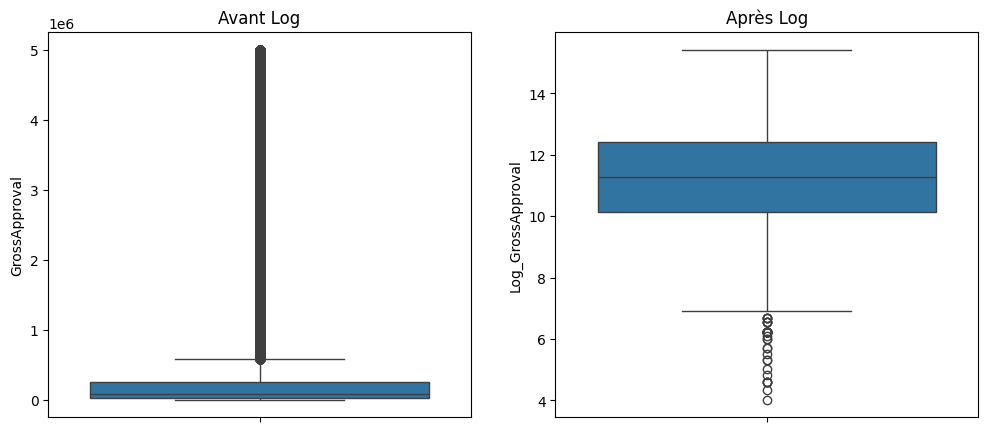

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['GrossApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_GrossApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

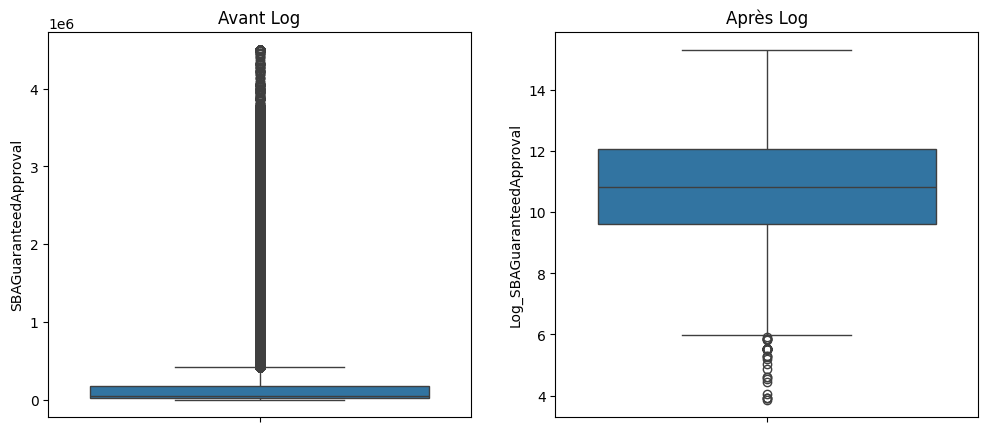

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['SBAGuaranteedApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_SBAGuaranteedApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

In [57]:
# Les contrats ou on a 0 temps restants
df = df[df["TerminMonths"]!=0]
df['TerminMonths_cut'] = pd.qcut(df["TerminMonths"], q=20, duplicates ='drop')

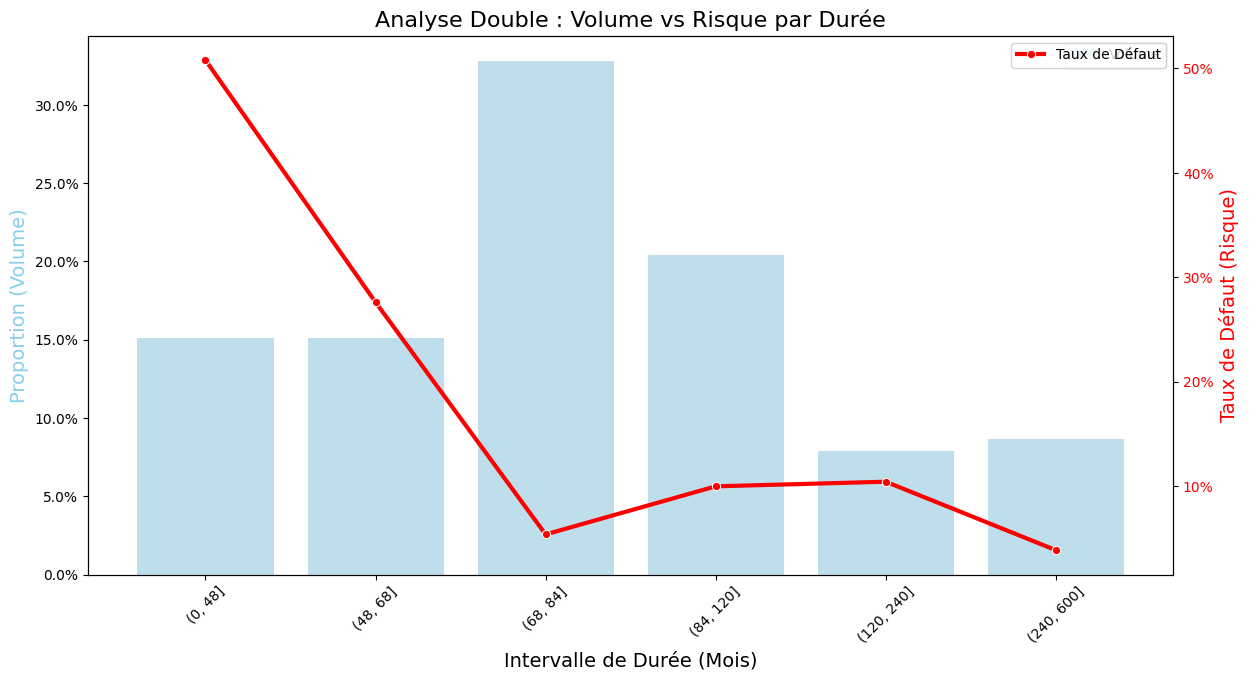

In [73]:
volume = df['TerminMonths_cut'].value_counts(normalize=True).sort_index()
volume.index = volume.index.astype(str) 

risk = df.groupby('TerminMonths_cut', observed=False)['LoanStatus'].mean().sort_index()
risk.index = risk.index.astype(str)    

fig, ax1 = plt.subplots(figsize=(14, 7))


sns.barplot(x=volume.index, y=volume.values, ax=ax1, color='skyblue', alpha=0.6, label='Volume')
ax1.set_ylabel("Proportion (Volume)", fontsize=14, color='skyblue')
ax1.set_xlabel("Intervalle de Durée (Mois)", fontsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = ax1.twinx()

sns.lineplot(x=risk.index, y=risk.values, ax=ax2, color='red', marker='o', linewidth=3, label='Taux de Défaut')

ax2.set_ylabel("Taux de Défaut (Risque)", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Analyse Double : Volume vs Risque par Durée", fontsize=16)
ax1.tick_params(axis='x', rotation=45) # Rotation des étiquettes

plt.show()

In [74]:
bins_cut = [0, 48, 68, 84, 120, 240, 600] # On est obligé de regrouper 60-68 avec la catégorie précédante car pas assez d'obs mais très diff 

df['TerminMonths_cut'] = pd.cut(df['TerminMonths'], bins=bins_cut)
df['TerminMonths_cut'].value_counts(normalize=True)

TerminMonths_cut
(68, 84]      0.327819
(84, 120]     0.204111
(48, 68]      0.151326
(0, 48]       0.151016
(240, 600]    0.086846
(120, 240]    0.078881
Name: proportion, dtype: float64

In [75]:
df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_53595/1342425714.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})


,LoanStatus
TerminMonths_cut,
"(0, 48]",0.507976
"(48, 68]",0.276138
"(68, 84]",0.053765
"(84, 120]",0.099802
"(120, 240]",0.104233
"(240, 600]",0.038691


In [76]:
df["JobsSupported_cut"] = pd.qcut(df["JobsSupported"], q=20, duplicates='drop')

In [77]:
df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",
                                    "JobsSupported" : "count"})

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_53595/2790225200.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",


,LoanStatus,JobsSupported
JobsSupported_cut,,
"(-0.001, 1.0]",0.153624,291927
"(1.0, 2.0]",0.175868,122518
"(2.0, 3.0]",0.199425,87306
"(3.0, 4.0]",0.192243,84929
"(4.0, 5.0]",0.195971,64887
"(5.0, 6.0]",0.188398,57214
"(6.0, 8.0]",0.183726,75128
"(8.0, 10.0]",0.168724,58581
"(10.0, 12.0]",0.168240,38665


In [78]:
bins_jobs = [-0.001, 2, 3, 8, 10, 20, 99999]

df['JobsSupported_cut'] = pd.cut(df['JobsSupported'], bins=bins_jobs)
df['JobsSupported_cut'].value_counts(normalize=True)

JobsSupported_cut
(-0.001, 2.0]      0.384905
(3.0, 8.0]         0.262047
(10.0, 20.0]       0.118024
(20.0, 99999.0]    0.099534
(2.0, 3.0]         0.081083
(8.0, 10.0]        0.054406
Name: proportion, dtype: float64

In [79]:
df

,BorrState,BankName,BankState,GrossApproval,SBAGuaranteedApproval,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,ProjectCounty,ProjectState,SBADistrictOffice,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd,Industry,IndustryName,Mean_GrossApproval_by_Subprogram,Log_GrossApproval,Log_SBAGuaranteedApproval,TerminMonths_cut,JobsSupported_cut,State_Yearly_Investment,Log_State_Investment,State_Avg_Loan_Size,State_Med_Loan_Size,US_Total_Investment,State_Market_vs_US,Industry_Yearly_Investment,Log_Industry_Investment,Industry_Avg_Loan_Size,Industry_Med_Loan_Size,US_Total_Yearly_Investment,Industry_Market_vs_other_industries,difference_pret_assurance,ratio_pret_assurance,ApprovalMonth,ApprovalQuarter
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-10-01,TX,Loans from Old Closed Lenders,DC,460400.0,345300.0,2000,1999-10-31,Preferred Lenders Program,Guaranty,217,811113.0,HARRIS,TX,HOUSTON DISTRICT OFFICE,CORPORATION,1,0,12.0,1,81,Other Services,NaN,13.039853,12.752172,"(120, 240]","(10.0, 20.0]",1.168594e+09,20.879067,335032.763761,174000.0,8.924467e+09,0.130943,6.595925e+08,20.307133,241697.520704,139000.0,8.924467e+09,0.073908,115100.0,0.75,10,4
1999-10-01,MA,"Bank of America, National Association",NC,36000.0,18000.0,2000,1999-10-31,SBA Express Program,FA$TRK (Small Loan Express),36,inconnu,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,CORPORATION,0,0,2.0,0,in,Inconnu,NaN,10.491302,9.798183,"(0, 48]","(-0.001, 2.0]",1.588504e+08,18.883473,168630.954352,75000.0,8.924467e+09,0.017799,3.823353e+09,22.064394,228450.798817,115000.0,8.924467e+09,0.428412,18000.0,0.50,10,4
1999-10-01,WI,"Associated Bank, National Association",WI,100000.0,80000.0,2000,1999-11-30,7a General,Guaranty,120,inconnu,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,CORPORATION,0,0,0.0,0,in,Inconnu,NaN,11.512935,11.289794,"(84, 120]","(-0.001, 2.0]",1.294919e+08,18.679129,198607.156442,110000.0,8.924467e+09,0.014510,3.823353e+09,22.064394,228450.798817,115000.0,8.924467e+09,0.428412,20000.0,0.80,10,4
1999-10-01,TX,LegacyTexas Bank,TX,151000.0,113250.0,2000,1999-12-31,Preferred Lenders Program,Guaranty,84,235410.0,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,CORPORATION,0,0,3.0,0,23,Construction,NaN,11.925042,11.637362,"(68, 84]","(2.0, 3.0]",1.168594e+09,20.879067,335032.763761,174000.0,8.924467e+09,0.130943,3.635961e+08,19.711554,180355.210813,100000.0,8.924467e+09,0.040741,37750.0,0.75,10,4
1999-10-01,MI,Fifth Third Bank,OH,653000.0,489750.0,2000,2000-10-31,Preferred Lenders Program,Guaranty,180,551112.0,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,PARTNERSHIP,0,0,23.0,0,55,Management,NaN,13.389334,13.101652,"(120, 240]","(20.0, 99999.0]",2.303141e+08,19.254955,294143.219668,150000.0,8.924467e+09,0.025807,7.110200e+06,15.777041,374221.052632,300000.0,8.924467e+09,0.000797,163250.0,0.75,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-06,PA,Manufacturers and Traders Trust Company,NY,25000.0,12500.0,2025,2025-06-16,SBA Express Program,FA$TRK (Small Loan Express),60,722515.0,CHESTER,PA,PHILADELPHIA DISTRICT OFFICE,CORPORATION,0,0,0.0,0,72,Accommodation/Food,NaN,10.126671,9.433564,"(48, 68]","(-0.001, 2.0]",1.951100e+06,14.483904,150084.615385,75000.0,1.382803e+08,0.014110,1.055750e+07,16.172347,251369.047619,150000.0,1.382803e+08,0.076349,12500.0,0.50,6,2
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,63750.0,2025,2025-07-30,Preferred Lenders Program,Guaranty,60,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CORPORATION,0,0,10.0,1,81,Other Services,NaN,11.225257,11.062740,"(48, 68]","(8.0, 10.0]",6.250000e+05,13.345509,156250.000000,75000.0,1.382803e+08,0.004520,1.396860e+07,16.452323,258677.777778,150000.0,1.382803e+08,0.101017,11250.0,0.85,6,2
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,37500.0,2025,2025-07-16,Preferred Lenders Program,Guaranty,12,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CO

### B. Création de features intéréssantes

In [80]:
df.columns

Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Mean_GrossApproval_by_Subprogram',
       'Log_GrossApproval', 'Log_SBAGuaranteedApproval', 'TerminMonths_cut',
       'JobsSupported_cut', 'State_Yearly_Investment', 'Log_State_Investment',
       'State_Avg_Loan_Size', 'State_Med_Loan_Size', 'US_Total_Investment',
       'State_Market_vs_US', 'Industry_Yearly_Investment',
       'Log_Industry_Investment', 'Industry_Avg_Loan_Size',
       'Industry_Med_Loan_Size', 'US_Total_Yearly_Investment',
       'Industry_Market_vs_other_industries', 'difference_pret_assurance',
       'ratio_pret_assurance', 'ApprovalMonth', 'ApprovalQuarter'],
      dtype='object

In [81]:
# Une variable intéréssante pourrait être la taille du marché
# On peut utiliser le montant total des sommes investies comme proxy 
df['State_Yearly_Investment'] = df.groupby(['ApprovalFY', 'BorrState'])['GrossApproval'].transform('sum')
#Transfo logarithmique pour une remise d'échelle
df['Log_State_Investment'] = np.log1p(df['State_Yearly_Investment'])

# Le montant moyen des prêts par etat et par an
df['State_Avg_Loan_Size'] = df.groupby(['ApprovalFY', 'BorrState'])['GrossApproval'].transform('mean')
df['State_Med_Loan_Size'] = df.groupby(['ApprovalFY', 'BorrState'])['GrossApproval'].transform('median')
# Le montant total investit aux US par an
df['US_Total_Investment'] = df.groupby('ApprovalFY')['GrossApproval'].transform('sum')

# La part de chaque état dans les montants investis des US
df['State_Market_vs_US'] = df['State_Yearly_Investment'] / df['US_Total_Investment']

In [82]:
df['Industry_Yearly_Investment'] = df.groupby(['ApprovalFY', 'IndustryName'])['GrossApproval'].transform('sum')
df['Log_Industry_Investment'] = np.log1p(df['Industry_Yearly_Investment'])
df['Industry_Avg_Loan_Size'] = df.groupby(['ApprovalFY', 'IndustryName'])['GrossApproval'].transform('mean')
df['Industry_Med_Loan_Size'] = df.groupby(['ApprovalFY', 'IndustryName'])['GrossApproval'].transform('median')
df['US_Total_Yearly_Investment'] = df.groupby('ApprovalFY')['GrossApproval'].transform('sum')
df['Industry_Market_vs_other_industries'] = df['Industry_Yearly_Investment'] / df['US_Total_Yearly_Investment']

In [83]:
df["difference_pret_assurance"] = df["GrossApproval"] - df["SBAGuaranteedApproval"]
df["ratio_pret_assurance"] = df["SBAGuaranteedApproval"] / df["GrossApproval"]

In [84]:
df['ApprovalMonth'] = df.index.month
df['ApprovalQuarter'] = df.index.quarter

In [85]:
df = df.drop(columns={"BorrZip"})

KeyError: "['BorrZip'] not found in axis"

In [ ]:
df

In [ ]:
gdp = pd.read_csv("input/GDP.csv")
gdp["observation_date"] = pd.to_datetime(gdp["observation_date"])
gdp["year"] = gdp.observation_date.dt.year
gdp["gdp_year_lag1"] = gdp.GDP.shift(1)
gdp = gdp[["year", "gdp_year_lag1"]]
df = pd.merge(df, gdp, how="left", left_on = "ApprovalFY", right_on="year")

In [ ]:
gdp = pd.read_csv("input/GDP.csv")
gdp["observation_date"] = pd.to_datetime(gdp["observation_date"])
gdp["year"] = gdp.observation_date.dt.year

#On pred la croissance
gdp["GDP_Growth"] = gdp["GDP"].dropna().pct_change()
gdp["GDP_Growth_Lag1"] = gdp["GDP_Growth"].shift(1)
gdp_final = gdp[["year", "GDP_Growth_Lag1"]]

df = pd.merge(df, gdp_final, how="left", left_on="ApprovalFY", right_on="year")

In [86]:
df

,BorrState,BankName,BankState,GrossApproval,SBAGuaranteedApproval,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,ProjectCounty,ProjectState,SBADistrictOffice,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd,Industry,IndustryName,Mean_GrossApproval_by_Subprogram,Log_GrossApproval,Log_SBAGuaranteedApproval,TerminMonths_cut,JobsSupported_cut,State_Yearly_Investment,Log_State_Investment,State_Avg_Loan_Size,State_Med_Loan_Size,US_Total_Investment,State_Market_vs_US,Industry_Yearly_Investment,Log_Industry_Investment,Industry_Avg_Loan_Size,Industry_Med_Loan_Size,US_Total_Yearly_Investment,Industry_Market_vs_other_industries,difference_pret_assurance,ratio_pret_assurance,ApprovalMonth,ApprovalQuarter
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-10-01,TX,Loans from Old Closed Lenders,DC,460400.0,345300.0,2000,1999-10-31,Preferred Lenders Program,Guaranty,217,811113.0,HARRIS,TX,HOUSTON DISTRICT OFFICE,CORPORATION,1,0,12.0,1,81,Other Services,NaN,13.039853,12.752172,"(120, 240]","(10.0, 20.0]",1.168594e+09,20.879067,335032.763761,174000.0,8.924467e+09,0.130943,6.595925e+08,20.307133,241697.520704,139000.0,8.924467e+09,0.073908,115100.0,0.75,10,4
1999-10-01,MA,"Bank of America, National Association",NC,36000.0,18000.0,2000,1999-10-31,SBA Express Program,FA$TRK (Small Loan Express),36,inconnu,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,CORPORATION,0,0,2.0,0,in,Inconnu,NaN,10.491302,9.798183,"(0, 48]","(-0.001, 2.0]",1.588504e+08,18.883473,168630.954352,75000.0,8.924467e+09,0.017799,3.823353e+09,22.064394,228450.798817,115000.0,8.924467e+09,0.428412,18000.0,0.50,10,4
1999-10-01,WI,"Associated Bank, National Association",WI,100000.0,80000.0,2000,1999-11-30,7a General,Guaranty,120,inconnu,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,CORPORATION,0,0,0.0,0,in,Inconnu,NaN,11.512935,11.289794,"(84, 120]","(-0.001, 2.0]",1.294919e+08,18.679129,198607.156442,110000.0,8.924467e+09,0.014510,3.823353e+09,22.064394,228450.798817,115000.0,8.924467e+09,0.428412,20000.0,0.80,10,4
1999-10-01,TX,LegacyTexas Bank,TX,151000.0,113250.0,2000,1999-12-31,Preferred Lenders Program,Guaranty,84,235410.0,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,CORPORATION,0,0,3.0,0,23,Construction,NaN,11.925042,11.637362,"(68, 84]","(2.0, 3.0]",1.168594e+09,20.879067,335032.763761,174000.0,8.924467e+09,0.130943,3.635961e+08,19.711554,180355.210813,100000.0,8.924467e+09,0.040741,37750.0,0.75,10,4
1999-10-01,MI,Fifth Third Bank,OH,653000.0,489750.0,2000,2000-10-31,Preferred Lenders Program,Guaranty,180,551112.0,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,PARTNERSHIP,0,0,23.0,0,55,Management,NaN,13.389334,13.101652,"(120, 240]","(20.0, 99999.0]",2.303141e+08,19.254955,294143.219668,150000.0,8.924467e+09,0.025807,7.110200e+06,15.777041,374221.052632,300000.0,8.924467e+09,0.000797,163250.0,0.75,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-06,PA,Manufacturers and Traders Trust Company,NY,25000.0,12500.0,2025,2025-06-16,SBA Express Program,FA$TRK (Small Loan Express),60,722515.0,CHESTER,PA,PHILADELPHIA DISTRICT OFFICE,CORPORATION,0,0,0.0,0,72,Accommodation/Food,NaN,10.126671,9.433564,"(48, 68]","(-0.001, 2.0]",1.951100e+06,14.483904,150084.615385,75000.0,1.382803e+08,0.014110,1.055750e+07,16.172347,251369.047619,150000.0,1.382803e+08,0.076349,12500.0,0.50,6,2
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,63750.0,2025,2025-07-30,Preferred Lenders Program,Guaranty,60,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CORPORATION,0,0,10.0,1,81,Other Services,NaN,11.225257,11.062740,"(48, 68]","(8.0, 10.0]",6.250000e+05,13.345509,156250.000000,75000.0,1.382803e+08,0.004520,1.396860e+07,16.452323,258677.777778,150000.0,1.382803e+08,0.101017,11250.0,0.85,6,2
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,37500.0,2025,2025-07-16,Preferred Lenders Program,Guaranty,12,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CO

In [87]:
df.columns

Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Mean_GrossApproval_by_Subprogram',
       'Log_GrossApproval', 'Log_SBAGuaranteedApproval', 'TerminMonths_cut',
       'JobsSupported_cut', 'State_Yearly_Investment', 'Log_State_Investment',
       'State_Avg_Loan_Size', 'State_Med_Loan_Size', 'US_Total_Investment',
       'State_Market_vs_US', 'Industry_Yearly_Investment',
       'Log_Industry_Investment', 'Industry_Avg_Loan_Size',
       'Industry_Med_Loan_Size', 'US_Total_Yearly_Investment',
       'Industry_Market_vs_other_industries', 'difference_pret_assurance',
       'ratio_pret_assurance', 'ApprovalMonth', 'ApprovalQuarter'],
      dtype='object

In [88]:
crosstab_counts = pd.crosstab(df['ProcessingMethod'], df['Subprogram'])
chi2, p, dof, expected = chi2_contingency(crosstab_counts)

print(f"P-value : {p}")

if p < 0.05:
    print("lien signi")
else:
    print("pas de liason")

P-value : 0.0
lien signi


In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * min(r-1, k-1)))

score = cramers_v(df['ProcessingMethod'], df['Subprogram'])

print(f"V de Cramer entre ProcessingMethod et Subprogram : {score:.4f}")

In [ ]:
# on peut enlever ProcessingMethod et garder seulement subprogram
df = df.drop(columns={"ProcessingMethod"})

In [ ]:
df

### C. Nouvelle partie feature engineering

J'ai pas bien compris ce que tu avais fait au dessus dans la partie feture engineering donc j'ai repris a 0 plus moins pour qu'on puisse comparer

#### a. On va crée des features temporelles

In [89]:
# Age du pret 
df["Delay_Disbursement_Days"] = (df["FirstDisbursementDate"] - df.index).dt.days 

In [90]:
# Durée d'approbation du pret (ca pourra nous permettre de voir l'influence des crises
df["ApprovalMonth"] = df.index.month # en mois
df["ApprovalQuarter"] = df.index.quarter # en trimestre 

In [91]:
# Impact des crises
years = df.index.year
df["Crisis2008"] = ((years >= 2007) & (years <= 2009)).astype(int)
df["CovidPeriod"] = ((years >= 2020) & (years <= 2021)).astype(int)

In [92]:
df[["Delay_Disbursement_Days","ApprovalMonth","ApprovalQuarter","Crisis2008","CovidPeriod"]].describe(include="all")

,Delay_Disbursement_Days,ApprovalMonth,ApprovalQuarter,Crisis2008,CovidPeriod
count,1.076745e+06,1.076745e+06,1.076745e+06,1.076745e+06,1.076745e+06
mean,7.241360e+01,6.549062e+00,2.504296e+00,1.613660e-01,3.063399e-02
std,1.569612e+02,3.373798e+00,1.097536e+00,3.678683e-01,1.723241e-01
min,-6.020000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,4.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,3.300000e+01,7.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
75%,6.700000e+01,9.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
max,9.132000e+03,1.200000e+01,4.000000e+00,1.000000e+00,1.000000e+00


#### b. Mtn on crée des features sur les montants 

In [93]:
# Plus le prêt est garanti, plus il est risqué côté SBA (risque comportemental).
df["GuaranteeRatio"] = df["SBAGuaranteedApproval"] / df["GrossApproval"]

In [94]:
# Montant normalisé par secteur sur état
df["SectorPremium"] = df["GrossApproval"] / df.groupby("IndustryName")["GrossApproval"].transform("mean")

In [95]:
# Montant sur capacité d'emploi
df["Approval_per_Job"] = df["GrossApproval"] / (df["JobsSupported"] + 1)

#### c. Features géographiques

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_53595/2602878099.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_risk.values,y=state_risk.index,palette="Reds")


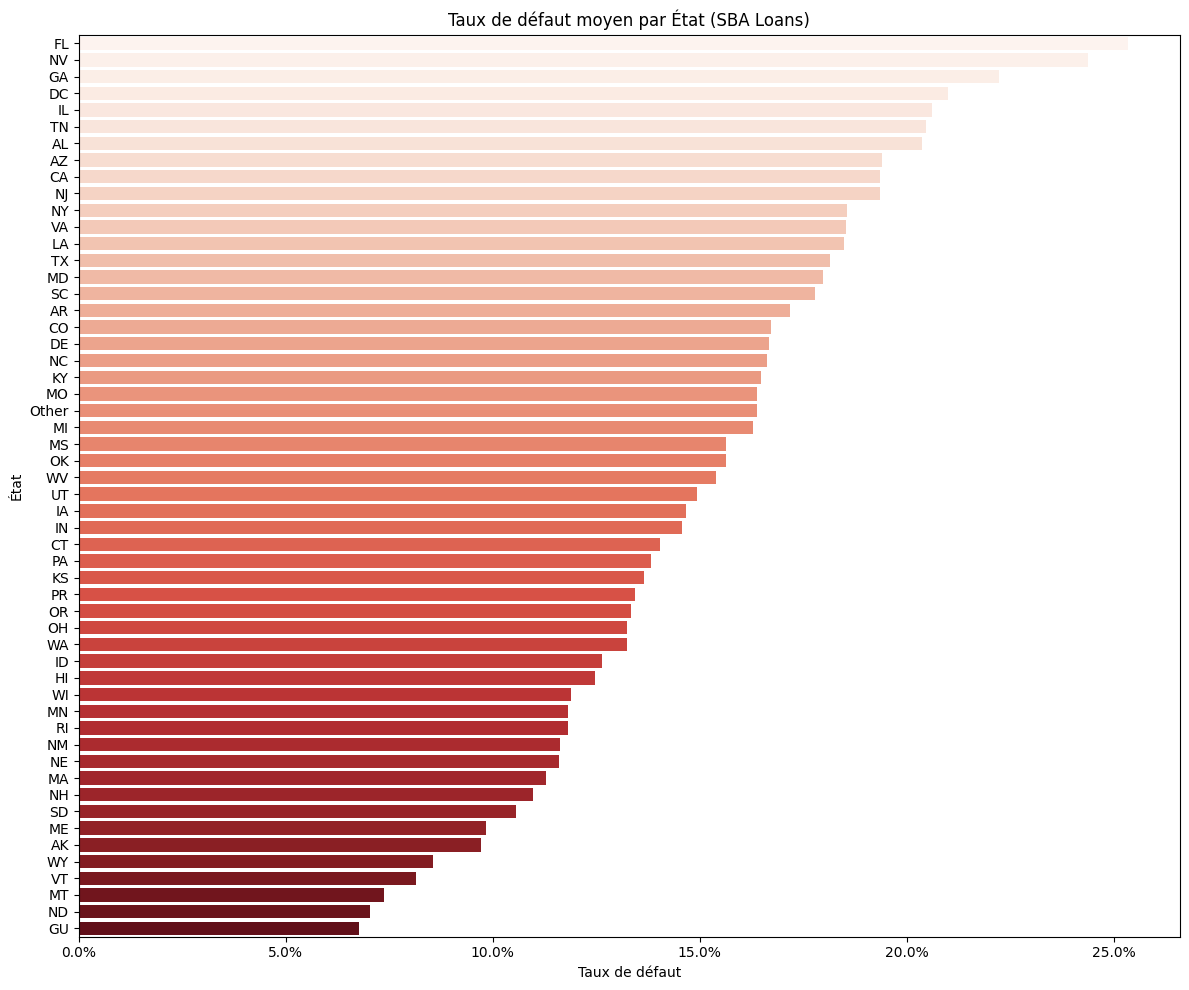

In [96]:
# Calcul du taux de défaut par État
state_risk = df.groupby("BorrState")["LoanStatus"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x=state_risk.values,y=state_risk.index,palette="Reds")
plt.title("Taux de défaut moyen par État (SBA Loans)")
plt.xlabel("Taux de défaut")
plt.ylabel("État")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

In [97]:
# En gros on guette si les banques locales pretent mieux (plus facilement à leurs clients)
df["IsLocalBank"] = (df["BorrState"] == df["BankState"]).astype(int)

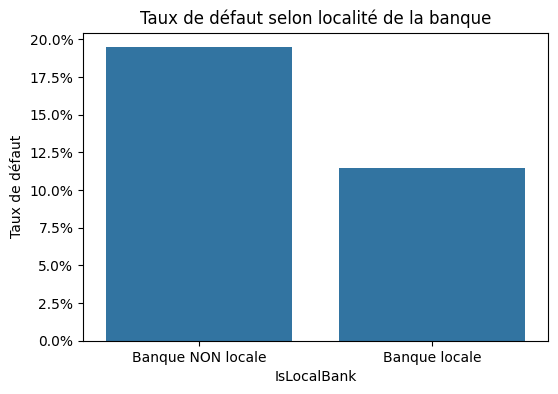

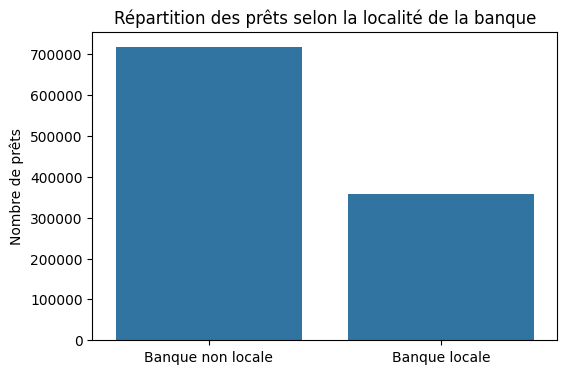

In [98]:
# Graphique pour voir que les banques qui sont non locales connaissent plus de défauts
local_risk = df.groupby("IsLocalBank")["LoanStatus"].mean()

plt.figure(figsize=(6,4))
sns.barplot(
    x=local_risk.index.map({0: "Banque NON locale", 1: "Banque locale"}),
    y=local_risk.values
)
plt.title("Taux de défaut selon localité de la banque")
plt.ylabel("Taux de défaut")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="IsLocalBank")
plt.xticks([0,1], ["Banque non locale", "Banque locale"])
plt.title("Répartition des prêts selon la localité de la banque")
plt.xlabel("")
plt.ylabel("Nombre de prêts")
plt.show()

In [99]:
# Askip grv important : on regarde par exemple si dans un lieu géographique x secteur d'activité c'est risqué 
df["Sector_State"] = df["IndustryName"] + "_" + df["BorrState"]

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_53595/2434887337.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_state_risk.values,y=sector_state_risk.index,palette="Reds")


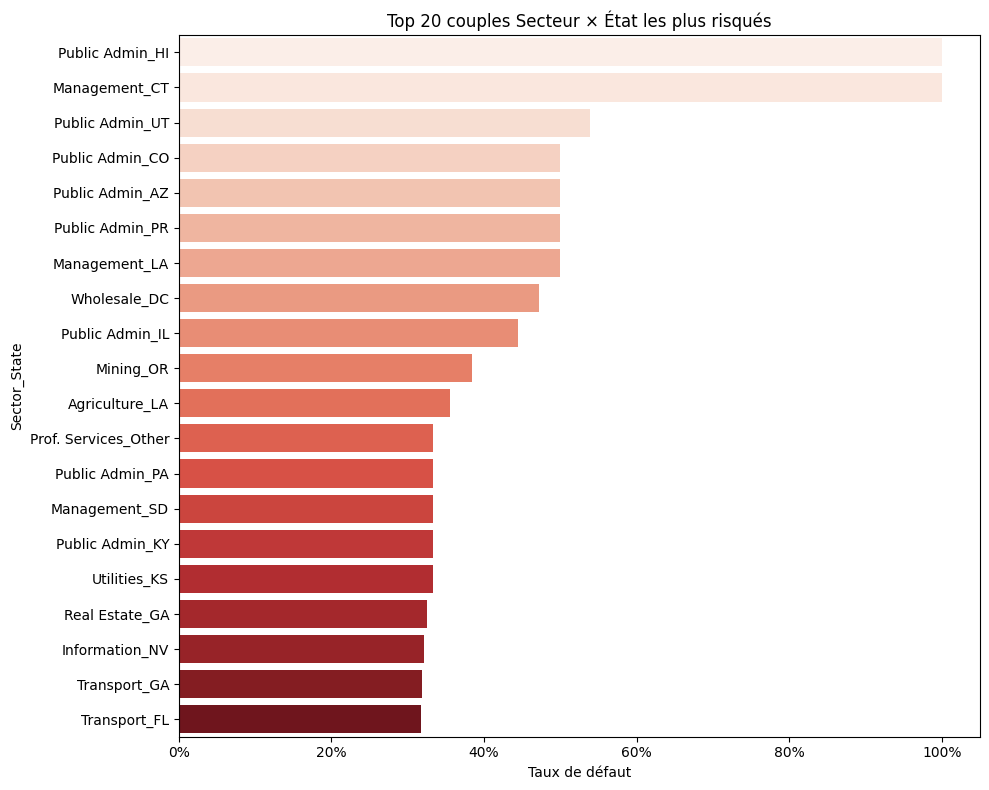

In [100]:
sector_state_risk = (df.groupby("Sector_State")["LoanStatus"].mean().sort_values(ascending=False).head(20))
plt.figure(figsize=(10,8))
sns.barplot(x=sector_state_risk.values,y=sector_state_risk.index,palette="Reds")
plt.title("Top 20 couples Secteur × État les plus risqués")
plt.xlabel("Taux de défaut")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

#### d. Features historiques

(A utiliser plutot dans la base train)

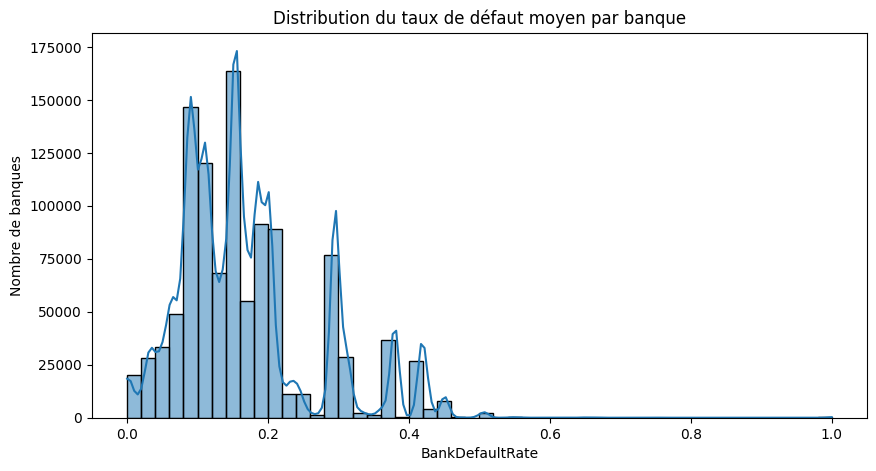

In [101]:
# On crée le taux de défaut moyen par banque
bank_default_rate = df.groupby("BankName")["LoanStatus"].mean()
df["BankDefaultRate"] = df["BankName"].map(bank_default_rate)
plt.figure(figsize=(10,5))
sns.histplot(df["BankDefaultRate"], bins=50, kde=True)
plt.title("Distribution du taux de défaut moyen par banque")
plt.xlabel("BankDefaultRate")
plt.ylabel("Nombre de banques")
plt.show()

Par exemple si on veut interpréter ici ce que l'on a fait : 150 000 banquesont un taux de défaut autour de 10%

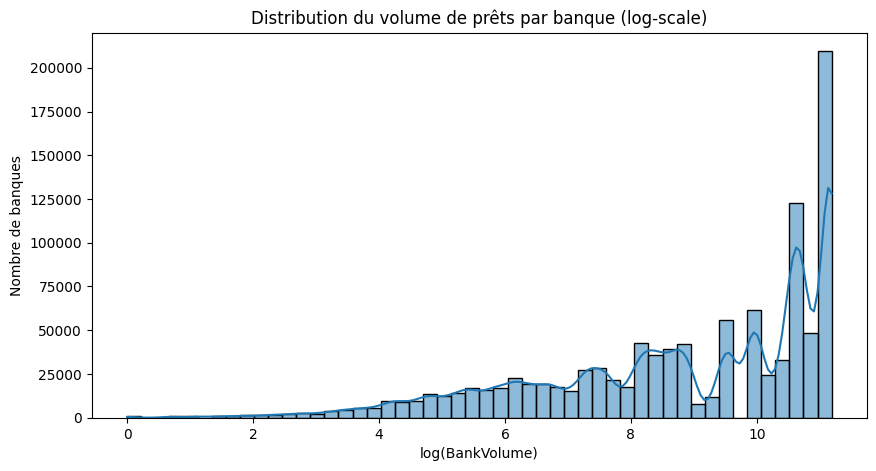

In [102]:
# Taille des prets par banques
bank_volume = df.groupby("BankName")["LoanStatus"].size()
df["BankVolume"] = df["BankName"].map(bank_volume)
plt.figure(figsize=(10,5))
sns.histplot(np.log(df["BankVolume"]), bins=50, kde=True)
plt.title("Distribution du volume de prêts par banque (log-scale)")
plt.xlabel("log(BankVolume)")
plt.ylabel("Nombre de banques")
plt.show()

En gros,vu qu'on est en log, les banques qui sont le plus a droite accordent autour de 400 prets, une barre très haute autour de 10–11 signifie qu’il y a énormément de banques très actives qui font des milliers de prets SBA (a verifier ca je suis pas sur c'est bzr pour moi)


#### e. On va essayer d'utiliser le VIX

In [45]:
vix = pd.read_csv("/Users/arthurdestribats/Downloads/VIXCLS.csv")
vix.columns = ["Date", "VIX"]

vix["Date"] = pd.to_datetime(vix["Date"])
vix.set_index("Date", inplace=True)

In [46]:
start_date = df.index.min()
end_date = df.index.max()
vix = vix.loc[start_date:end_date]
vix.head()

,VIX
Date,
1999-10-01,24.93
1999-10-04,24.46
1999-10-05,24.79
1999-10-06,22.06
1999-10-07,23.58


In [47]:
vix.tail()

,VIX
Date,
2025-06-26,16.59
2025-06-27,16.32
2025-06-30,16.73
2025-07-01,16.83
2025-07-02,16.64


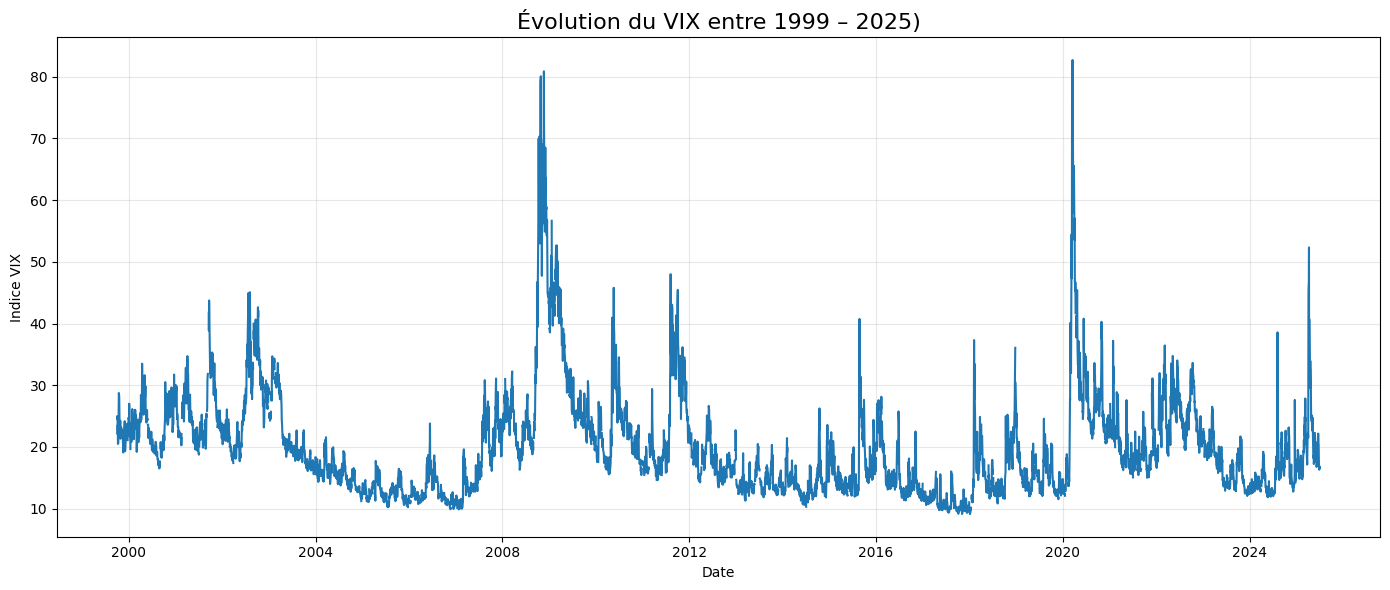

In [50]:
plt.figure(figsize=(14,6))
plt.plot(vix.index, vix["VIX"], linewidth=1.5)
plt.title("Évolution du VIX entre 1999 – 2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Indice VIX")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
df["VIX"] = df.index.map(vix["VIX"])

<Axes: title={'center': 'VIX'}, xlabel='ApprovalDate'>

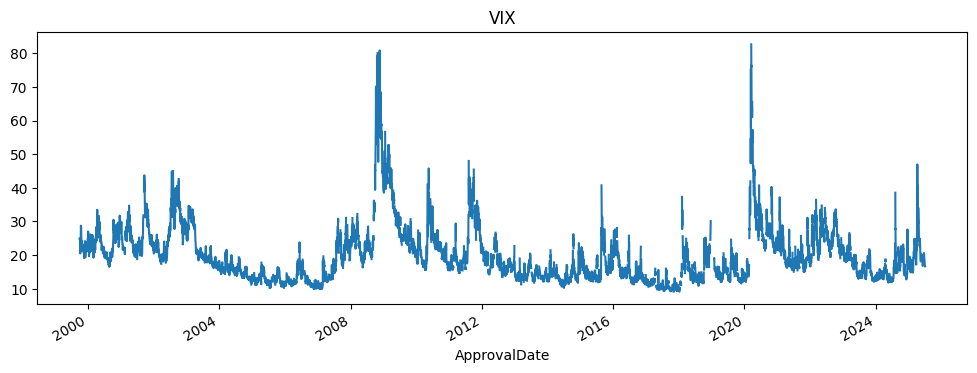

In [71]:
df["VIX"].plot(figsize=(12,4), title="VIX")

In [72]:
df["VIX"].isna().mean()

np.float64(0.013965467174704255)

1,4% des lignes ont des valeurs manquantes dans le VIX

/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_59134/3645382010.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vix_default = df.groupby("VIX_bin")["LoanStatus"].mean()
/var/folders/z3/3ngskbls2mx_wxmgwmm5p17m0000gn/T/ipykernel_59134/3645382010.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vix_default.index.astype(str), y=vix_default.values, palette="Reds")


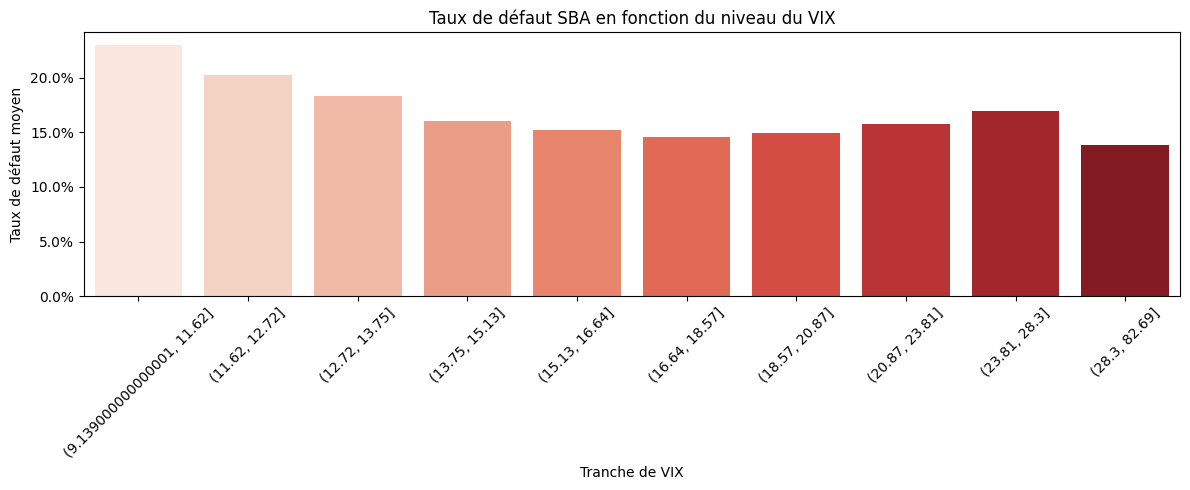

In [81]:
df["VIX_bin"] = pd.qcut(df["VIX"], q=10, duplicates="drop")
vix_default = df.groupby("VIX_bin")["LoanStatus"].mean()

plt.figure(figsize=(12,5))
sns.barplot(x=vix_default.index.astype(str), y=vix_default.values, palette="Reds")
plt.xticks(rotation=45)
plt.title("Taux de défaut SBA en fonction du niveau du VIX")
plt.ylabel("Taux de défaut moyen")
plt.xlabel("Tranche de VIX")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

Le taux de défaut SBA ne monte pas en période où le VIX est élevé. Au contraire, on observe des taux de défaut plus élevés lorsque le VIX est bas. Cela s’explique par des comportements d’offre de crédit : en période de stabilité (VIX faible), les banques sont plus laxistes et accordent davantage de prêts, y compris à des entreprises risquées. En période de volatilité élevée (VIX > 30), les banques sont plus prudentes : elles accordent moins de prêts mais à des emprunteurs plus soli
des. Ainsi, les prêts octroyés pendant les crises sont plus “sélectionnés”, ce qui fait mécaniquement baisser leur taux de défaut